In [1]:
#подключение к гугл_диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()
pd.set_option('display.max_columns', None)

# Предварительный анализ данных.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ВКР/electronika_regions.csv')

In [4]:
#кол-во строк и столбцов таблицы (357036*38)
df.shape

(357036, 39)

In [5]:
#наименования столбцов таблицы
list(df.columns)

['Order_ID',
 'Email_new',
 'Phone_new',
 'Source',
 'OrderDate',
 'время',
 'месяц',
 'ChangeDate',
 'DeliveryDate',
 'PaymentDate',
 'Status',
 'Status_ID',
 'OneClick',
 'CancelReason',
 'Actions',
 'DeliveryType',
 'PaymentType',
 'Area',
 'Store_ID',
 'FullSum',
 'Discount',
 'IM_Rozn_Sum',
 'Row_ID',
 'Articul',
 'Nom_Name',
 'NomGroup',
 'Quant',
 'RowPrice',
 'RowDiscount',
 'RowSum',
 'Brand',
 'TN',
 'TK',
 'NomFullPath',
 'Week',
 'Nom_ID',
 'Субъект',
 'Город',
 'Region']

Для каждого столбца выведем: количество уникальных значений, нулевых, NaNs и их долю, а также тип данных в столбцах.

In [6]:
def columnValues(df):
    row = [df.nunique(), ((df == 0) | (df == '0')).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data = []
for column in df:
    data.append([column] + columnValues(df[column]))

print(tabulate(data, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|--------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID     |         166794 |             0 |            0 |         0   | object      |
| Email_new    |          99284 |         61516 |            0 |         0   | object      |
| Phone_new    |         123135 |          7575 |            0 |         0   | object      |
| Source       |              4 |             0 |            0 |         0   | object      |
| OrderDate    |             61 |             0 |            0 |         0   | object      |
| время        |          58549 |             0 |            0 |         0   | object      |
| месяц        |              2 |             0 |            0 |         0   | int64       |
| ChangeDate   |         155189 |             0 |            0 |         0   | object      |
| DeliveryDate |            100 |             0 |            0 |      

*Столбцы Email_new и Phone_new содержат схожие данные, идентифицирующие покупателя. Оставляем столбец с номерами телефонов, так как он содержит гораздо меньше нулевых значений (7575), в то время как столбец с электронными адресами - 61 516 нулевых значений. При этом номера телефонов по электронным адресам нельзя никак идентифицировать, т.к. у покупателей с "нулевыми" номерами телефонов e-mail также не указан. Следовательно, столбец Email_new и строки с "нулевыми" номерами телефонов необходимо удалить.*

In [7]:
#удаление столбца Email_new.
df = df.drop(columns=['Email_new'])
df.shape

(357036, 38)

In [8]:
#удаление строк с нулевыми номерами телефонов.
df = df.loc[(df['Phone_new'] != 0) & (df['Phone_new'] != '0')]
df.shape

(349461, 38)

In [9]:
#удаляем чеки, в которых присутствуют отрицательные скидки (возможные ошибки системы)
df = df.loc[~df['Order_ID'].isin(['5429143_BX', '5581960_BX', '5826714_BX'])]
df.shape

(349451, 38)

In [10]:
df[df['TK'].isna()][['Nom_Name', 'NomGroup', 'TK', 'TN']]

,Nom_Name,NomGroup,TK,TN
0,Доставка до точки выдачи,Доставка,NaN,NaN
4,"Доставка ""Стандарт"" зона 0",Доставка,NaN,NaN
6,Доставка до точки выдачи,Доставка,NaN,NaN
10,Доставка до точки выдачи,Доставка,NaN,NaN
11,"Доставка ""Стандарт"" зона 0",Доставка,NaN,NaN
...,...,...,...,...
357025,Доставка до точки выдачи,Доставка,NaN,NaN
357027,Доставка до точки выдачи,Доставка,NaN,NaN
357029,Доставка до точки выдачи,Доставка,NaN,NaN
357031,Доставка до точки выдачи,Доставка,NaN,NaN


In [11]:
#заполнение пустых значений TN и TK
df.loc[(df.Nom_Name == 'Клавиатура Samsung VG-KBD1000'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары для комп./ноутбуков/принтеров']
df.loc[(df.Nom_Name == 'Музыкальный центр LG CM9740'), ['TN', 'TK']] = ['ТВ-Аудио', 'Аудио-Видео']
df.loc[(df.Nom_Name == 'Колонки LG CMS9740F'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары для комп./ноутбуков/принтеров']
df.loc[(df.Nom_Name == 'Автокресло Nania Beone SP Plus Boomer Carmin'), ['TN', 'TK']] = ['Детские товары', 'Прогулки и путешествие']
df.loc[(df.Nom_Name == 'Кроватка СКВ-5 544036 п.2 бук'), ['TN', 'TK']] = ['Детские товары', 'Детская комната']
df.loc[(df.Nom_Name == 'Apple iPad Pro ML0H2RU/A Wi-Fi 32Gb gold планшет'), ['TN', 'TK']] = ['Цифровая Техника', 'Планшеты']
df.loc[(df.Nom_Name == 'Apple iPad Pro ML2J2RU/A Wi-Fi Cell 128Gb  silver планшет'), ['TN', 'TK']] = ['Цифровая Техника', 'Планшеты']
df.loc[(df.Nom_Name == 'Автокресло Nania Beone SP Plus Boomer Carmin'), ['TN', 'TK']] = ['Детские товары', 'Прогулки и путешествие']
df.loc[(df.Nom_Name == 'Ресивер+сабвуфер Sony HCD-GT3D'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары ТВ-Аудио']

In [12]:
# Удалим строки, где в качестве категории товара фигурируют услуги
df = df[df['TN'].notna() & (df['TN'] != 'Услуги')]
df.shape

(186887, 38)

In [13]:
#удаляем строки с нулевыми значениями RowSum, т.к. нам не нужны "бесплатные" товары
df = df[df['RowSum'] != 0]
df.shape

(186471, 38)

In [14]:
#удаляем строки с ошибками, дублированными и тестовыми заказами
df = df.loc[~df['CancelReason'].isin(['Тестовый заказ', 'Несколько заказов', 'Дублирование заказа',
                  'Дублирование заказа техническое', 'Ошибка в модели'])]
df.shape

(181758, 38)

In [15]:
#по столбцу Status также можно исключить дублированные заказы
df = df.loc[~df['Status'].isin(['Дубль заказа'])]
df.shape

(181755, 38)

Для построения рекомендаций нам понадобятся только те пользователи, у которых есть несколько заказов. Будем рассматривать только те случаи, когда их не менее 2.

In [16]:
tmp = df.groupby(['Phone_new', 'Order_ID', 'NomGroup'])['RowSum'].count().reset_index().groupby(['Phone_new', 'Order_ID'])['NomGroup'].count().reset_index()
phones = tmp.groupby('Phone_new')['Order_ID'].count()[tmp.groupby('Phone_new')['Order_ID'].count() > 2].index
df = df[df['Phone_new'].isin(phones)]

# df.to_csv('/content/drive/MyDrive/ВКР/over_2_orders.csv', index=False)

# Сегментация

In [17]:
# рассчитаем сводные показатели
df_clients = pd.DataFrame()
gdf = df.groupby('Phone_new')
df_clients['goods_num'] = gdf['Quant'].sum() # количество купленных товаров
# df_clients['goods_num2'] = gdf['Quant'].count() # количество купленных товаров
df_clients['order_count'] = gdf['Order_ID'].nunique() # количество заказов
df_clients['goods_avg'] = df_clients['goods_num'] / df_clients['order_count'] # среднее количество товаров в чеке
# df_clients['goods_avg2'] = goods_num2 / order_count # среднее количество товаров в чеке
df_clients['avg_check'] = gdf['RowSum'].sum() / df_clients['order_count'] # средний чек
df_clients['paid_share'] = df_clients['order_count'].reset_index().join(df[df['Status'] == 'Выдан клиенту'].groupby('Phone_new')[['Order_ID']].nunique(), on='Phone_new', how='outer', lsuffix='_l').fillna(0).groupby('Phone_new')['Order_ID'].sum() / df_clients['order_count'] # доля выкупленных

In [18]:
df_clients = df_clients.join(
    pd.crosstab(
        df['Phone_new'],
        df['TN'],
        values=df['Quant'],
        aggfunc=lambda x: 1
    ).fillna(0) #.apply(lambda x: x / x.sum(), axis=1)
    , on='Phone_new'
)

df_clients = df_clients.join(
    pd.crosstab(
        df['Phone_new'],
        df['Region'],
        values=df['Quant'],
        aggfunc=lambda x: 1
    ).fillna(0) #.apply(lambda x: x / x.sum(), axis=1)
    , on='Phone_new'
)

df_clients = df_clients.reset_index()
df_clients

,Phone_new,goods_num,order_count,goods_avg,avg_check,paid_share,Автотовары,Аксессуары,Детские товары,"Игры, софт и развлечения",Климат,Крупная бытовая техника,Мебель,Мелкая бытовая техника,Сделай сам,Спорт и активный отдых,ТВ-Аудио,Товары для дома,Цифровая Техника,Приволжский ф.о.,Северо-Западный ф.о.,Сибирский ф.о.,Уральский ф.о.,Центральный ф.о.,Южный ф.о.
0,32565748-000000000,15.0,13,1.153846,14841.692308,0.615385,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,43553240-575054413251+75,7.0,7,1.000000,6936.714286,0.285714,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,55485656-57565656575275,205.0,181,1.132597,12411.254144,0.613260,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
3,55555555-51535356545777,3.0,3,1.000000,75659.666667,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,55555750-48525355535175,8.0,8,1.000000,5804.875000,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4695,55575757-56525150544979,12.0,8,1.500000,5533.000000,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4696,55575757-57545154575173,22.0,7,3.142857,16672.000000,0.142857,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4697,55575757-57545754495174,3.0,3,1.000000,3222.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4698,55575757-57565548505473,7.0,7,1.000000,7128.571429,0.571429,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## Корреляция

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.context('seaborn');

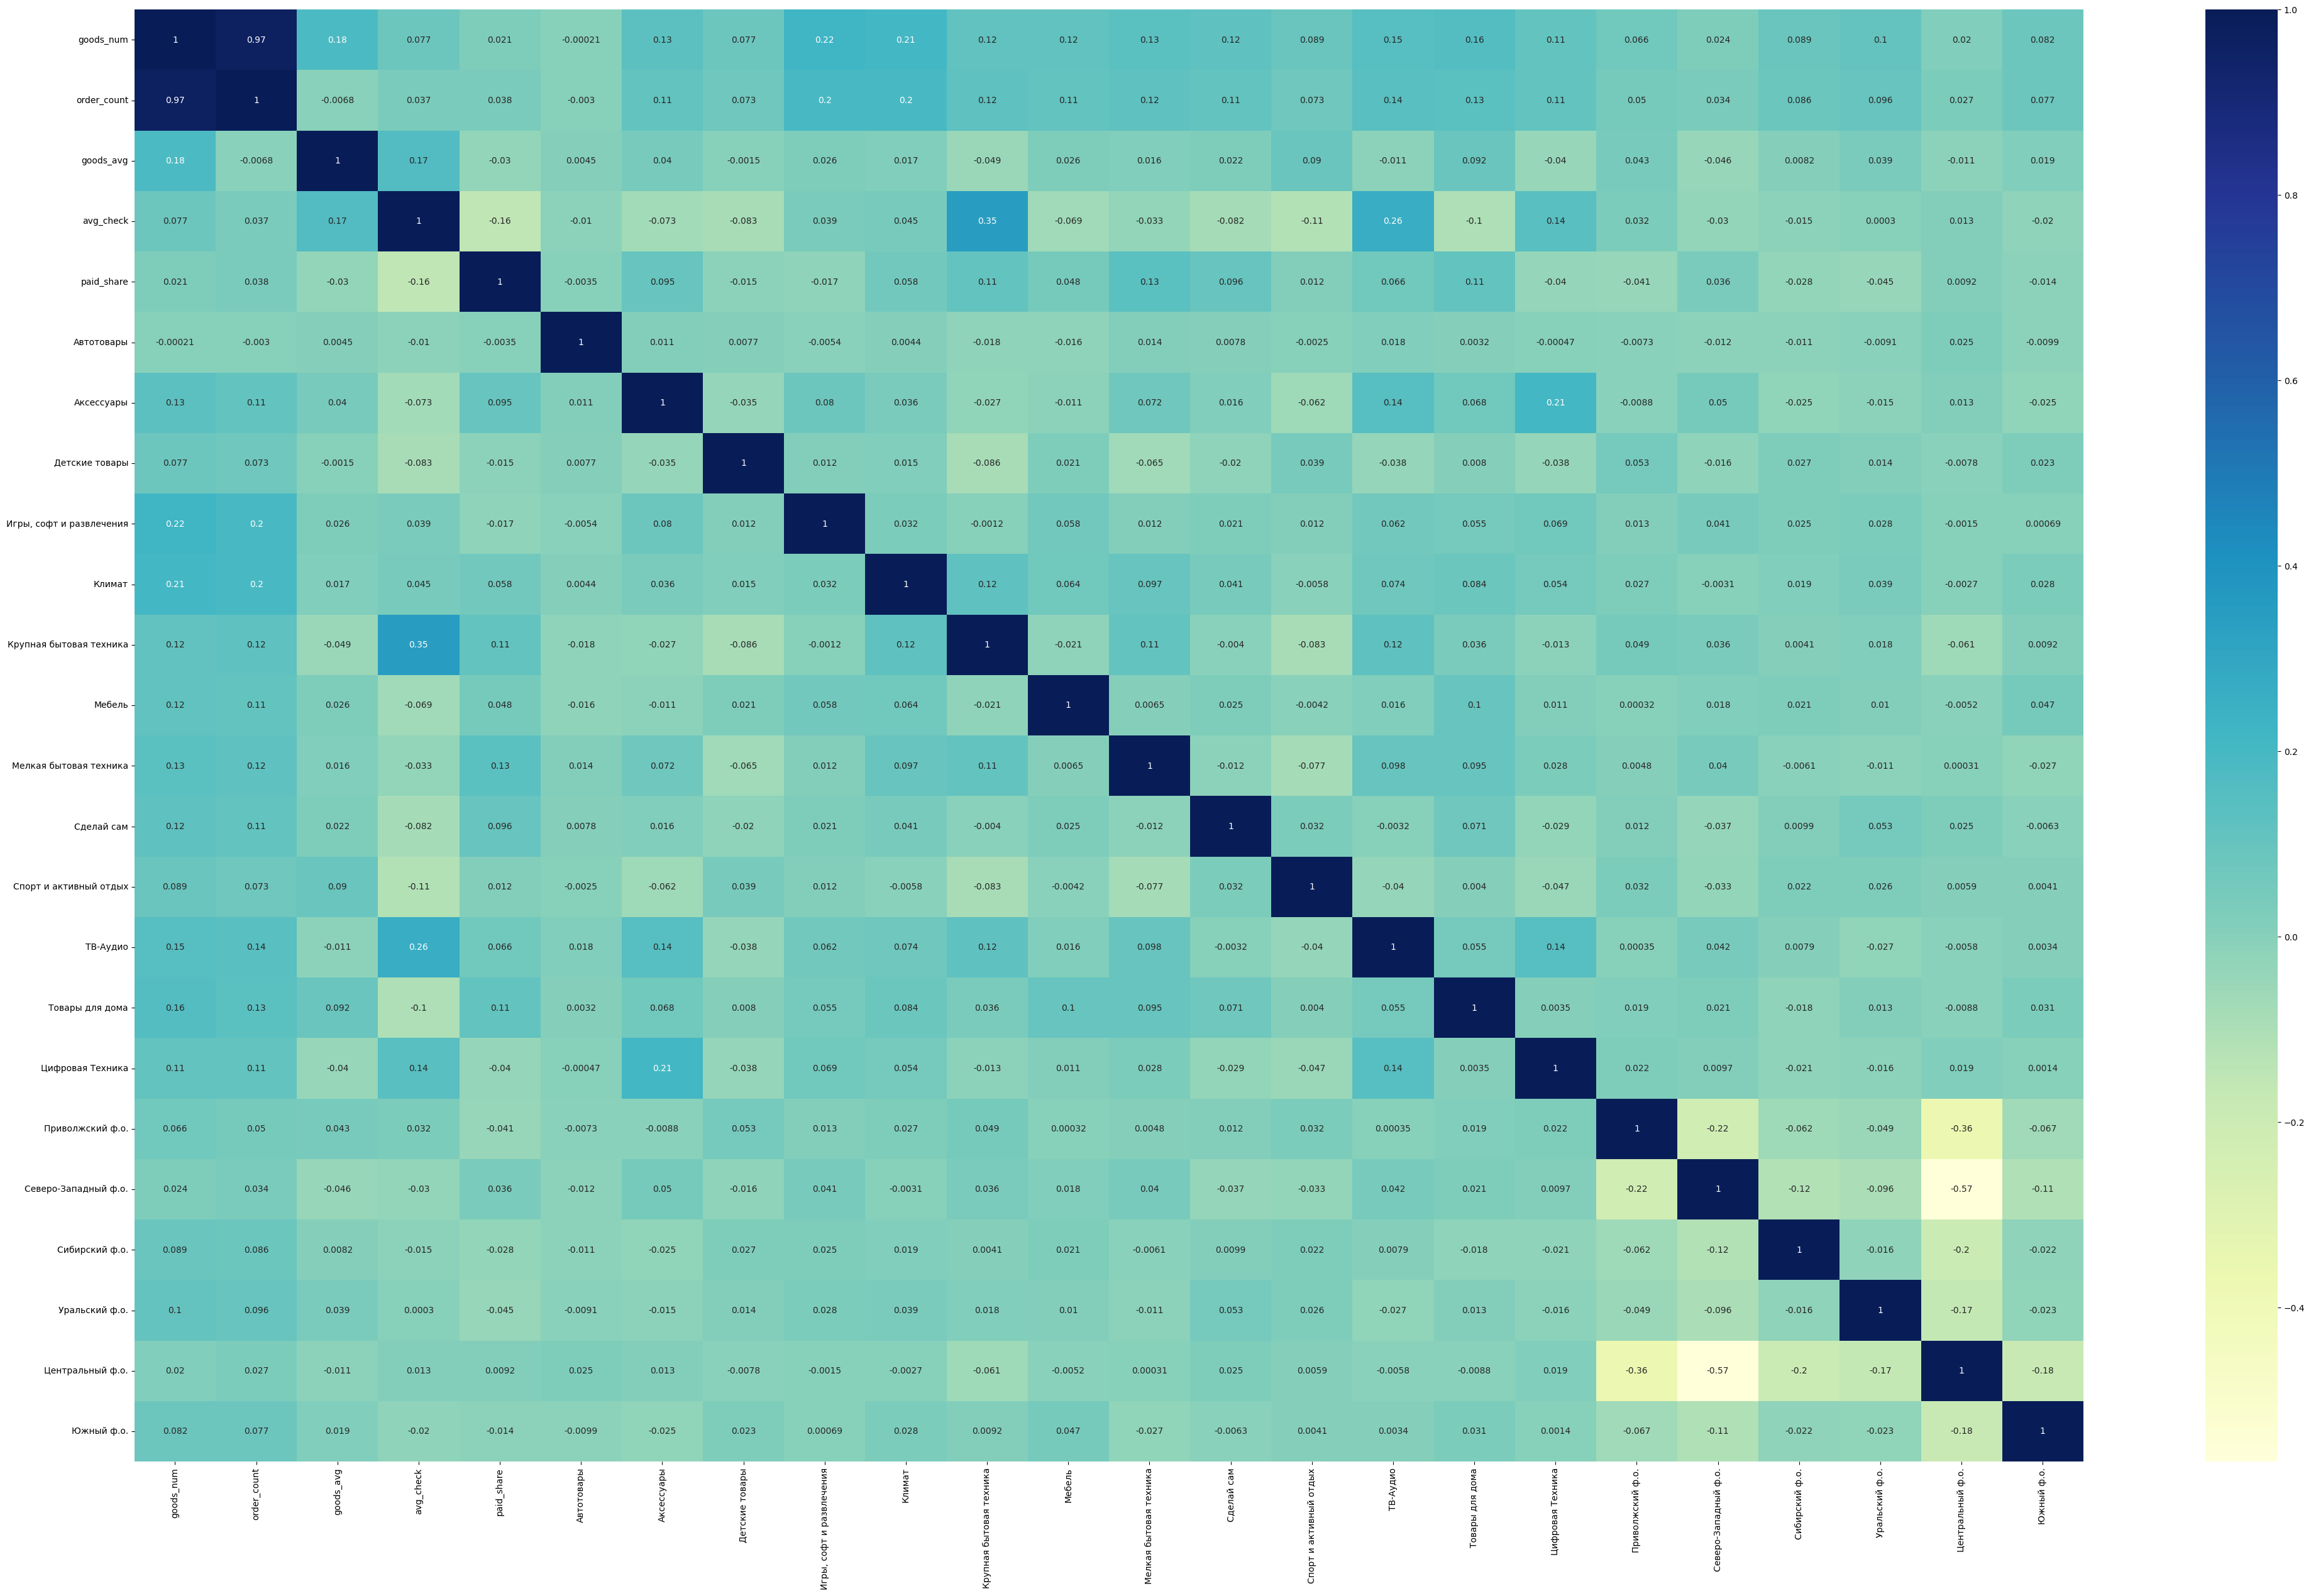

In [20]:
fig = plt.figure(figsize = (50, 30))
sns.heatmap(df_clients.corr(), annot=True, cmap='YlGnBu');

In [21]:
corr = df_clients.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,goods_num,order_count,goods_avg,avg_check,paid_share,Автотовары,Аксессуары,Детские товары,"Игры, софт и развлечения",Климат,Крупная бытовая техника,Мебель,Мелкая бытовая техника,Сделай сам,Спорт и активный отдых,ТВ-Аудио,Товары для дома,Цифровая Техника,Приволжский ф.о.,Северо-Западный ф.о.,Сибирский ф.о.,Уральский ф.о.,Центральный ф.о.,Южный ф.о.
goods_num,1.00,0.78,0.71,0.19,0.07,0.00,0.20,0.05,0.08,0.18,0.19,0.12,0.22,0.17,0.17,0.21,0.26,0.16,0.02,-0.03,0.01,0.00,0.03,0.02
order_count,0.78,1.00,0.19,0.18,0.03,-0.01,0.18,0.06,0.08,0.19,0.25,0.10,0.27,0.15,0.11,0.26,0.20,0.23,0.02,-0.01,0.01,0.00,0.02,0.01
goods_avg,0.71,0.19,1.00,0.09,0.05,0.02,0.13,0.03,0.05,0.08,0.01,0.09,0.05,0.10,0.15,0.03,0.19,0.01,0.02,-0.04,0.00,0.00,0.02,0.02
avg_check,0.19,0.18,0.09,1.00,-0.13,-0.01,-0.07,-0.07,0.04,0.09,0.49,-0.06,0.03,-0.05,-0.14,0.32,-0.12,0.22,0.04,-0.02,-0.01,0.01,-0.00,-0.01
paid_share,0.07,0.03,0.05,-0.13,1.00,-0.01,0.10,-0.02,-0.02,0.06,0.11,0.05,0.14,0.10,0.01,0.07,0.12,-0.03,-0.04,0.03,-0.03,-0.05,0.01,-0.01
Автотовары,0.00,-0.01,0.02,-0.01,-0.01,1.00,0.01,0.01,-0.01,0.00,-0.02,-0.02,0.01,0.01,-0.00,0.02,0.00,-0.00,-0.01,-0.01,-0.01,-0.01,0.02,-0.01
Аксессуары,0.20,0.18,0.13,-0.07,0.10,0.01,1.00,-0.04,0.08,0.04,-0.03,-0.01,0.07,0.02,-0.06,0.14,0.07,0.21,-0.01,0.05,-0.02,-0.01,0.01,-0.03
Детские товары,0.05,0.06,0.03,-0.07,-0.02,0.01,-0.04,1.00,0.01,0.02,-0.09,0.02,-0.06,-0.02,0.04,-0.04,0.01,-0.04,0.05,-0.02,0.03,0.01,-0.01,0.02
"Игры, софт и развлечения",0.08,0.08,0.05,0.04,-0.02,-0.01,0.08,0.01,1.00,0.03,-0.00,0.06,0.01,0.02,0.01,0.06,0.05,0.07,0.01,0.04,0.03,0.03,-0.00,0.00
Климат,0.18,0.19,0.08,0.09,0.06,0.00,0.04,0.02,0.03,1.00,0.12,0.06,0.10,0.04,-0.01,0.07,0.08,0.05,0.03,-0.00,0.02,0.04,-0.00,0.03


## Удаление выбросов

In [22]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [23]:
import pandas as pd
import numpy as np

In [24]:
%%time
outliers = IsolationForest(n_estimators=20, random_state=0).fit_predict(df_clients.drop(columns=['Phone_new']).values)  # fit 3 trees  
outliers = (outliers+1)//2

print('% of outliers with Isolation forest:', 1 - (np.sum(outliers) / df_clients.drop(columns=['Phone_new']).shape[0]))

% of outliers with Isolation forest: 0.19148936170212771
CPU times: user 81 ms, sys: 768 µs, total: 81.8 ms
Wall time: 85.9 ms


In [25]:
df_clients = df_clients.loc[np.array(df_clients.index)[outliers == 1]]

In [26]:
df_clients.shape

(3800, 25)

## Нормализация

In [27]:
from sklearn import preprocessing

In [28]:
scaler = preprocessing.StandardScaler()
# normalize
X = scaler.fit_transform(df_clients.drop(columns=['Phone_new']))

## Кластеризация K-means

In [29]:
from sklearn.cluster import KMeans #DBSCAN, AgglomerativeClustering, MeanShift, MiniBatchKMeans, OPTICS
from scipy.spatial.distance import cdist

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

### Метод локтя

In [30]:
%%time
# k means determine k
distortions = []
labels = []
K = range(1, 16)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k, max_iter=500, random_state=72, n_init=20).fit(X)
    labels.append(kmeanModel.predict(X))
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

100%|██████████| 15/15 [00:34<00:00,  2.32s/it]

CPU times: user 38 s, sys: 16.9 s, total: 54.9 s
Wall time: 34.8 s


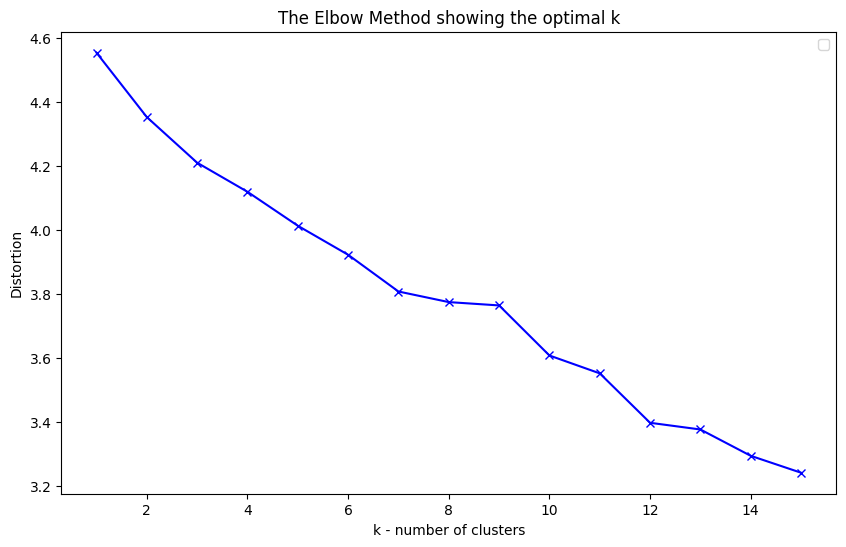

In [31]:
#определение оптимального к-ва кластеров методом локтя
plt.figure(figsize=(10, 6))
# plt.axvline(9, 0, 1, label='slope change #1', color='red')
# plt.axvline(13, 0, 1, label='slope change #2', color='orange')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.legend(); plt.show()

самые оптимальные: 7, 10 и 12 кластеров

### Дэвис-Боулдин

In [32]:
results_db_kmeans = {}
for i in tqdm(range(2, 16)):
    db_index = davies_bouldin_score(X, labels[i - 1])
    results_db_kmeans.update({i: db_index})

100%|██████████| 14/14 [00:00<00:00, 160.64it/s]


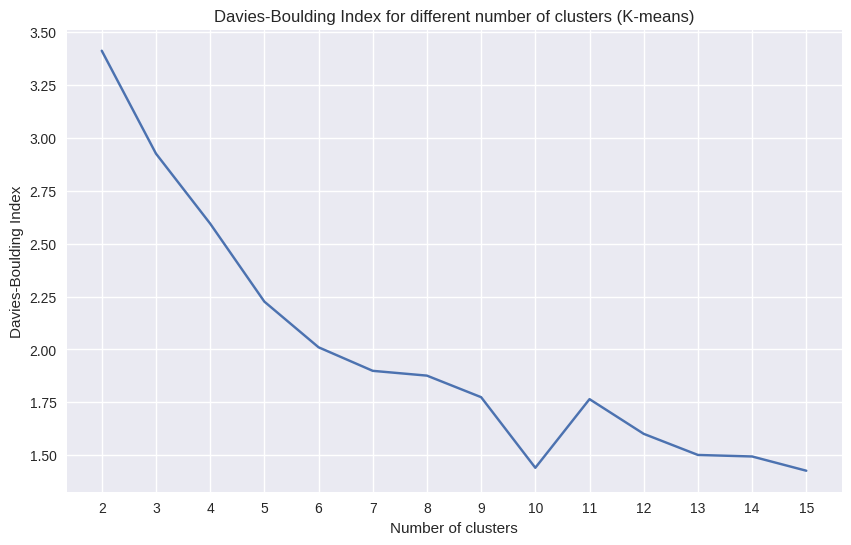

In [33]:
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))

plt.plot(list(results_db_kmeans.keys()), list(results_db_kmeans.values()))

plt.xticks(np.arange(2, 16, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Boulding Index')
plt.title('Davies-Boulding Index for different number of clusters (K-means)')
plt.show()

Самый оптимальный: 10

### Силуэт

In [34]:
results_sil_kmeans = {}
for i in tqdm(range(2, 16)):
    sil_score = silhouette_score(X, labels[i - 1])
    results_sil_kmeans.update({i: sil_score})

100%|██████████| 14/14 [00:03<00:00,  3.57it/s]


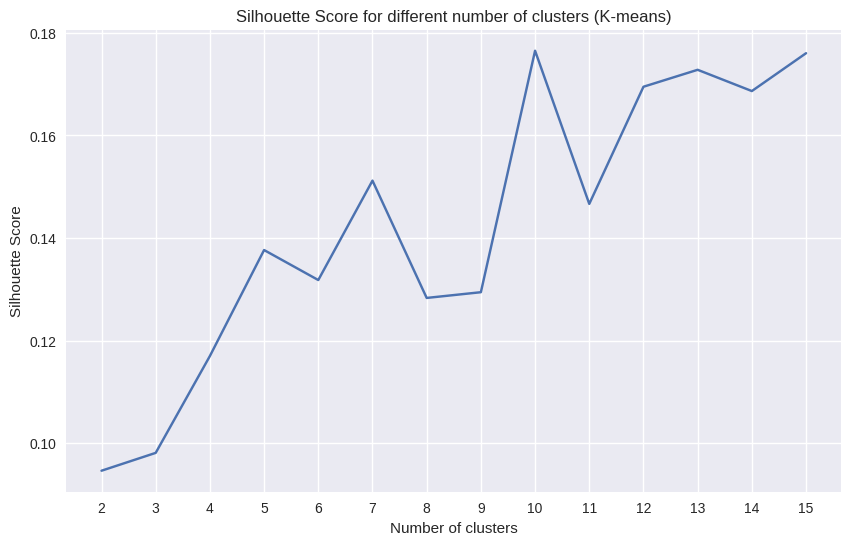

In [35]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_sil_kmeans.keys()), list(results_sil_kmeans.values()), label = 'Silhouette Score')

plt.xticks(np.arange(2, 16, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters (K-means)')
plt.show()

Самый оптимальный: 10

### Калински-Харабаш

In [36]:
results_ch_kmeans = {}
for i in tqdm(range(2, 16)):
    ch_score = calinski_harabasz_score(X, labels[i - 1])
    results_ch_kmeans.update({i: ch_score})

100%|██████████| 14/14 [00:00<00:00, 346.18it/s]


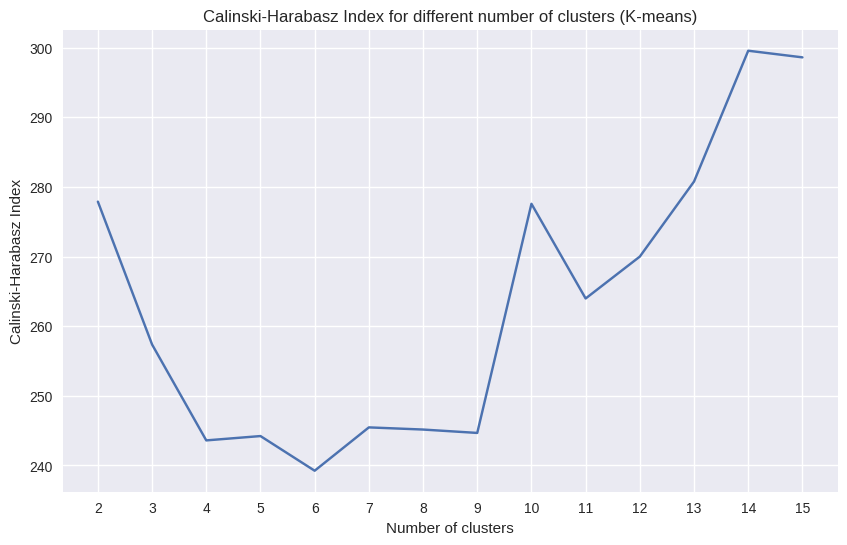

In [37]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_ch_kmeans.keys()), list(results_ch_kmeans.values()), label = 'Calinski-Harabasz Index')

plt.xticks(np.arange(2, 16, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for different number of clusters (K-means)')
plt.show()

Самый оптимальный: 10

**Вывод:** По итогам применения 4 методов выяснилось что наилучшее количество сегментов - 10 штук.

In [38]:
kmeanModel = KMeans(n_clusters=10, max_iter=500, random_state=805, n_init=10).fit(X)
labels = kmeanModel.predict(X)

df_clients['label'] = labels
# df = df.drop(columns=['label'])
df = df.join(df_clients.groupby('Phone_new')['label'].min(), on='Phone_new', how='inner')

# df.to_csv('/content/drive/MyDrive/ВКР/over_2_orders_clusters.csv', index=False) 352 372 467 469 473 653 739 805 829 893 993

### Кластеры

Посмотрим на долю каждого кластера.

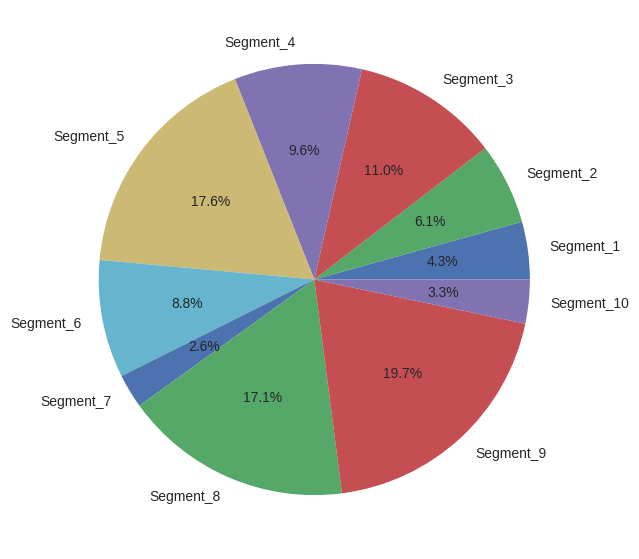

In [39]:
fig = plt.figure(figsize=(10, 7))
data = list(df_clients.groupby('label')['Phone_new'].count())
plt.pie(data, labels=[('Segment_' + str(i)) for i in range(1, 11)], autopct='%1.1f%%')

plt.show()

In [40]:
cluster_df = df_clients.groupby('label').mean()
cluster_df

,goods_num,order_count,goods_avg,avg_check,paid_share,Автотовары,Аксессуары,Детские товары,"Игры, софт и развлечения",Климат,Крупная бытовая техника,Мебель,Мелкая бытовая техника,Сделай сам,Спорт и активный отдых,ТВ-Аудио,Товары для дома,Цифровая Техника,Приволжский ф.о.,Северо-Западный ф.о.,Сибирский ф.о.,Уральский ф.о.,Центральный ф.о.,Южный ф.о.
label,,,,,,,,,,,,,,,,,,,,,,,,
0,16.146341,8.506098,2.661140,12959.010346,0.539116,0.000000,0.170732,0.054878,0.000000,0.012195,0.359756,0.000000,0.579268,0.152439,0.250000,0.158537,0.085366,0.189024,0.048780,0.274390,0.0,0.0,0.652439,0.030488
1,4.478448,3.642241,1.238383,7041.142932,0.561145,0.000000,0.090517,0.047414,0.004310,0.030172,0.155172,1.000000,0.245690,0.099138,0.060345,0.086207,0.073276,0.090517,0.099138,0.280172,0.0,0.0,0.577586,0.056034
2,4.663484,3.801909,1.237947,8861.684175,0.569859,0.000000,1.000000,0.000000,0.002387,0.009547,0.143198,0.000000,0.324582,0.083532,0.059666,0.195704,0.038186,0.446301,0.000000,0.193317,0.0,0.0,0.806683,0.011933
3,4.286501,3.498623,1.226171,12150.580131,0.471749,0.002755,0.162534,0.002755,0.000000,0.030303,0.360882,0.000000,0.300275,0.190083,0.184573,0.096419,0.082645,0.203857,1.000000,0.000000,0.0,0.0,0.035813,0.000000
4,4.286357,3.547226,1.215592,5620.702859,0.530024,0.002999,0.008996,0.000000,0.001499,0.013493,0.082459,0.000000,0.421289,0.313343,0.356822,0.043478,0.176912,0.085457,0.000000,0.008996,0.0,0.0,0.947526,0.055472
5,4.104167,3.523810,1.166929,7525.957396,0.504709,0.002976,0.089286,1.000000,0.000000,0.029762,0.107143,0.000000,0.157738,0.080357,0.145833,0.029762,0.044643,0.062500,0.166667,0.261905,0.0,0.0,0.547619,0.044643
6,4.164948,3.463918,1.191605,10533.308652,0.404005,0.000000,0.061856,0.113402,0.000000,0.061856,0.237113,0.072165,0.195876,0.237113,0.185567,0.030928,0.041237,0.154639,0.000000,0.000000,0.0,1.0,0.020619,0.000000
7,4.229231,3.647692,1.167049,22430.468297,0.414160,0.004615,0.007692,0.001538,0.009231,0.060000,0.555385,0.000000,0.213846,0.052308,0.020000,0.260000,0.023077,0.366154,0.000000,0.015385,0.0,0.0,0.935385,0.060000
8,4.002677,3.504685,1.143886,11330.401117,0.522671,0.000000,0.155288,0.000000,0.005355,0.041499,0.366801,0.000000,0.378849,0.171352,0.144578,0.170013,0.081660,0.153949,0.000000,1.000000,0.0,0.0,0.012048,0.000000


Посмотрим на распределение величин по кластерам

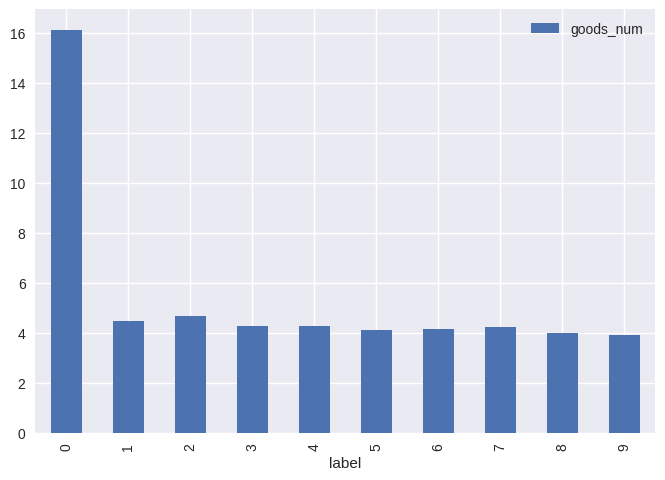

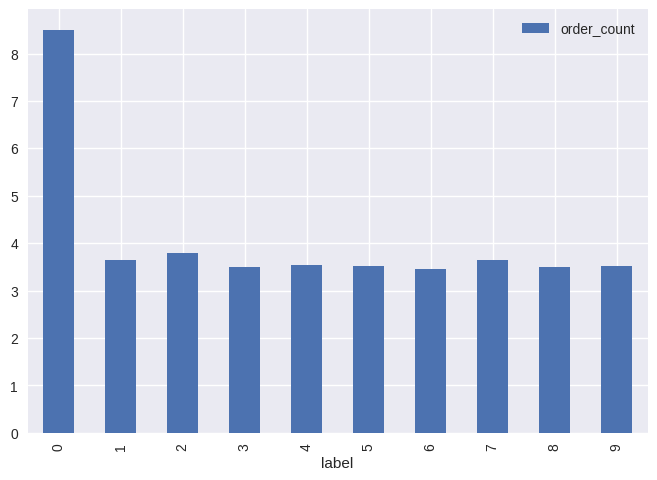

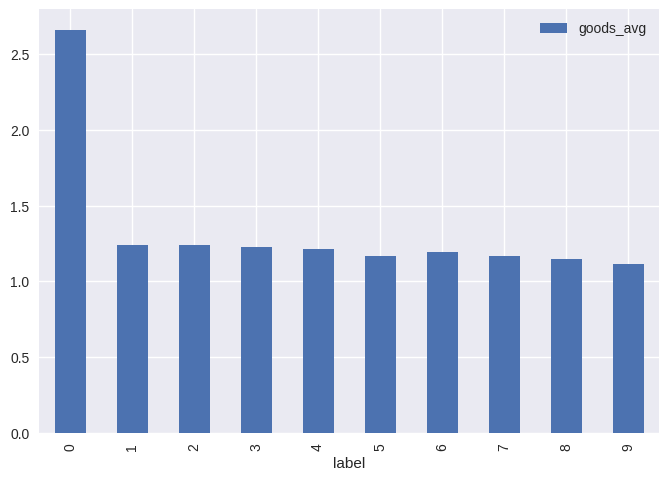

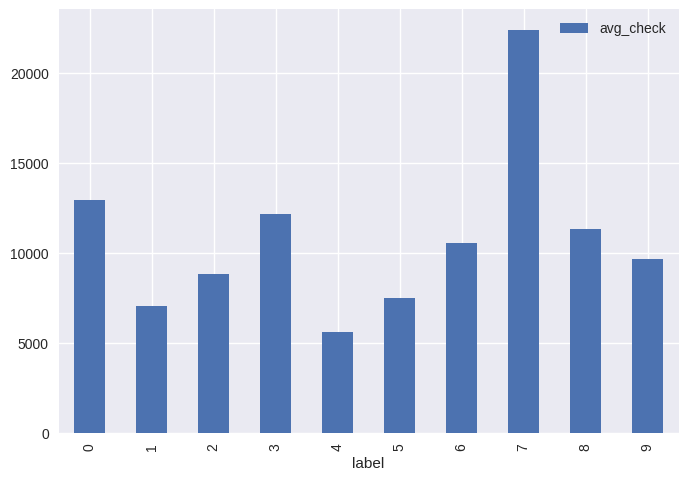

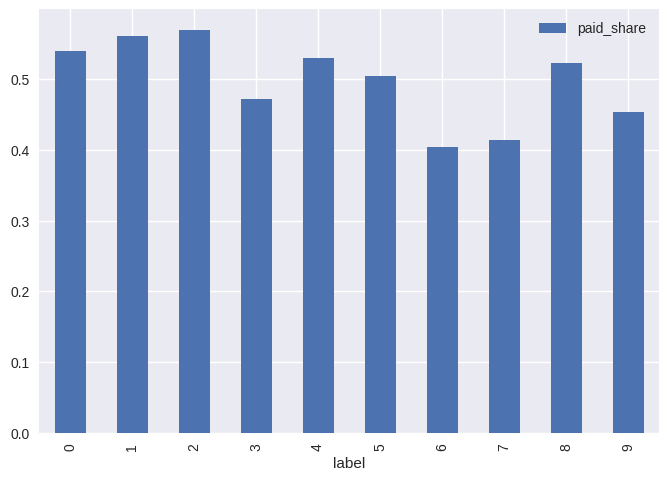

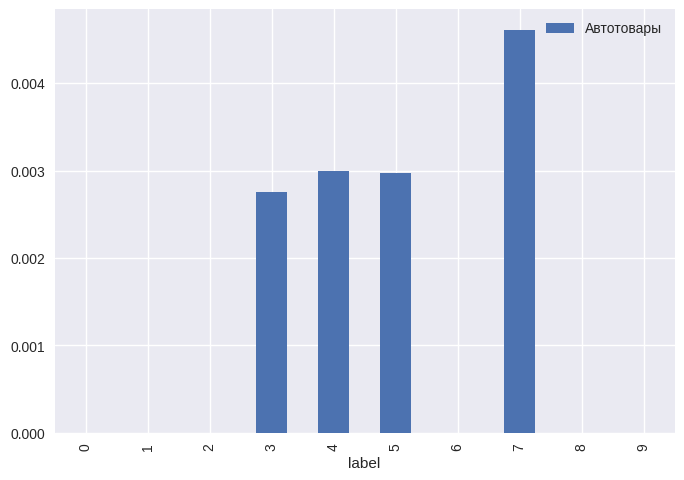

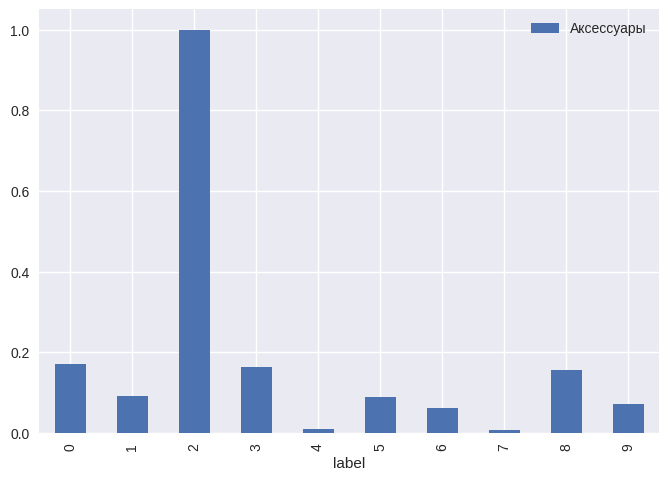

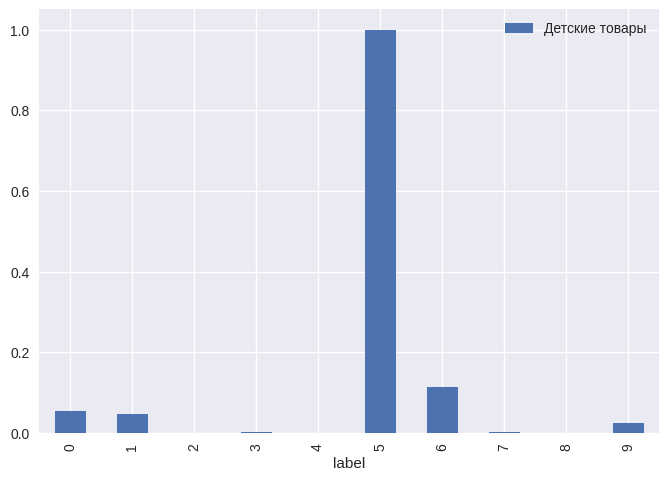

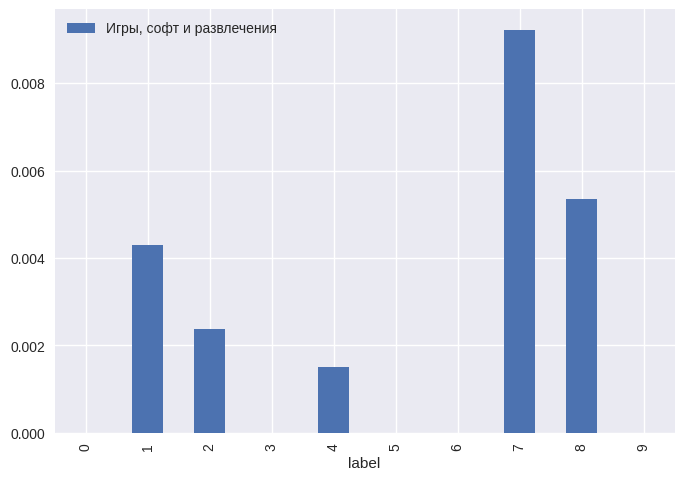

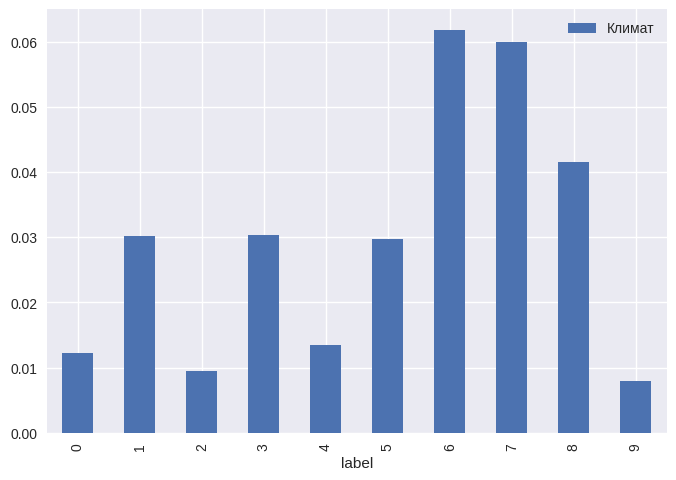

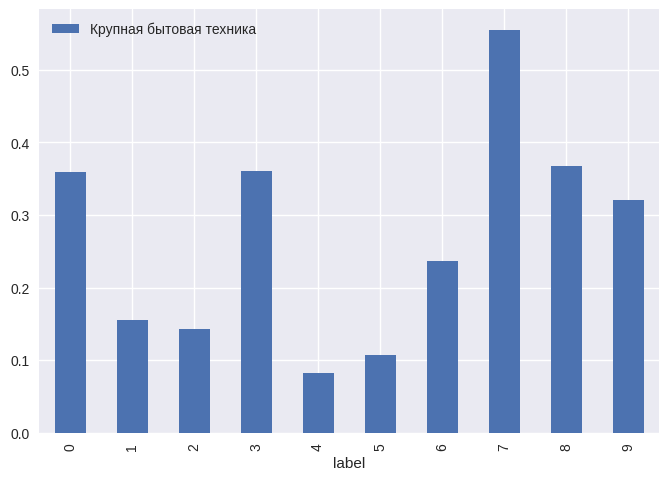

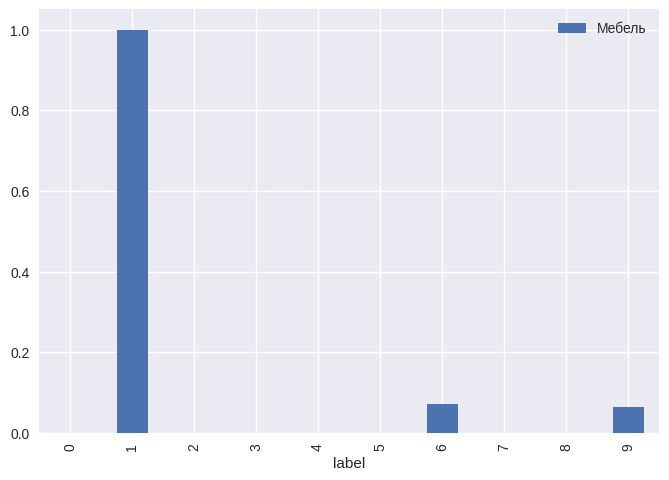

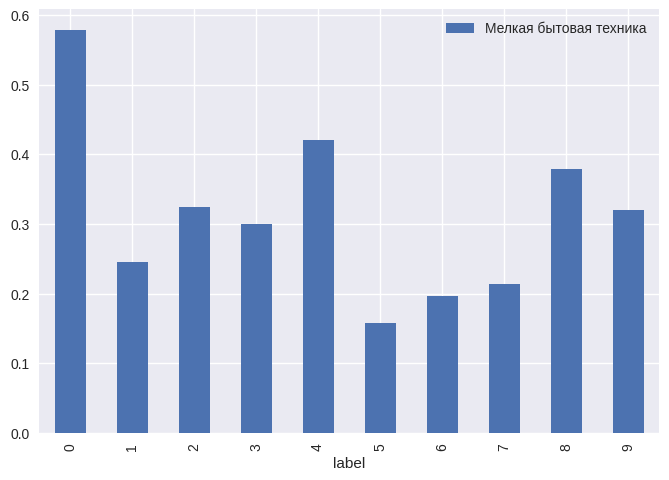

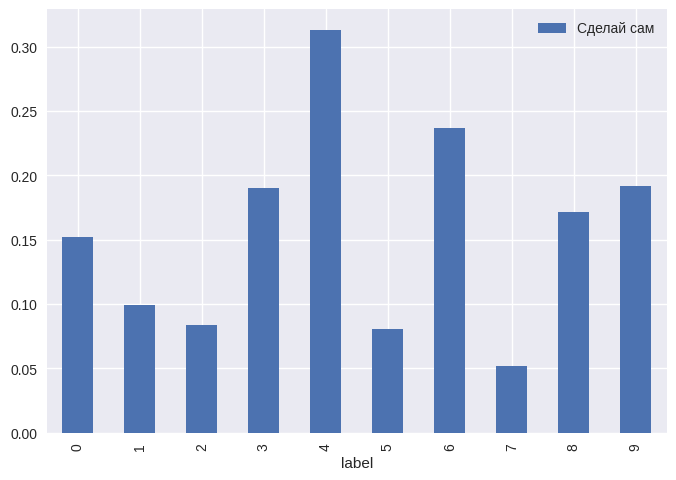

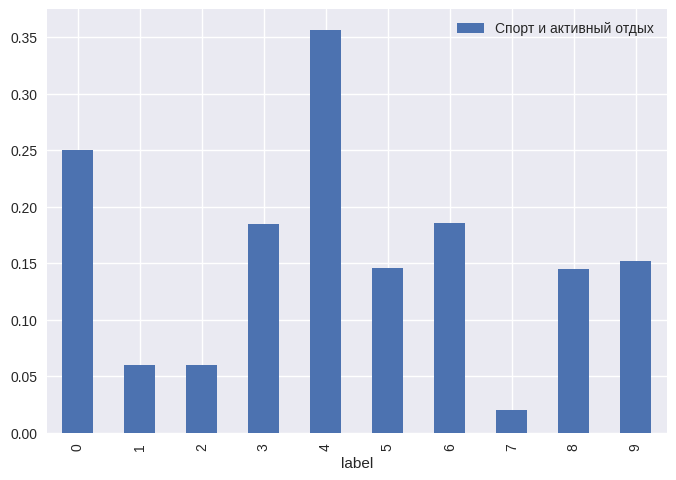

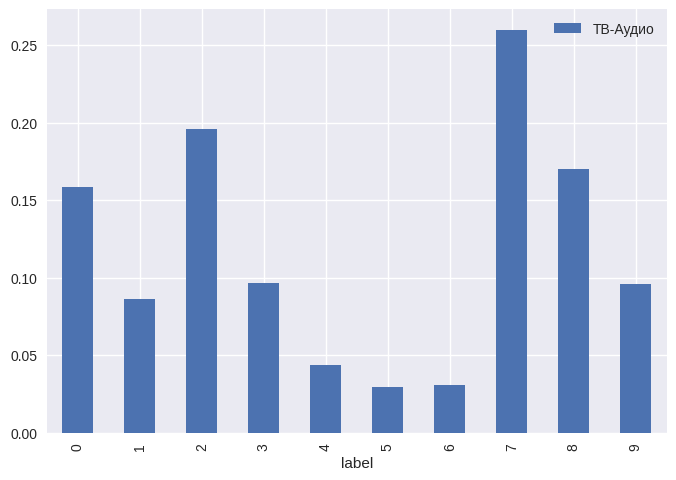

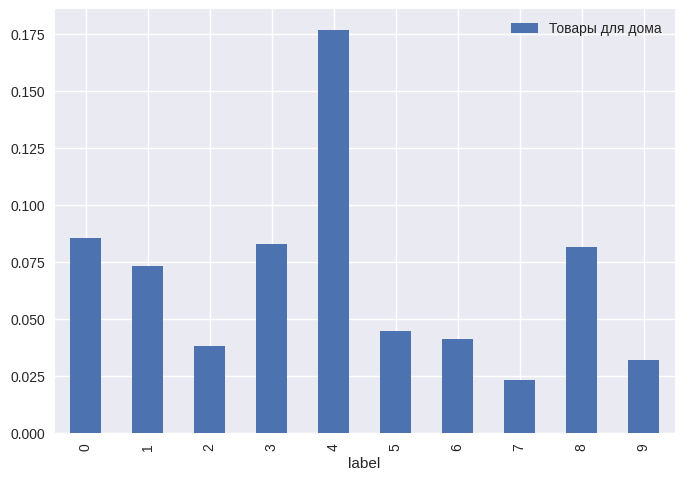

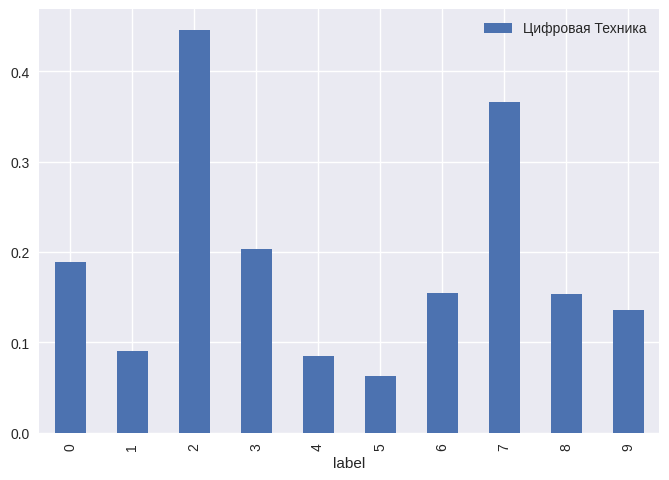

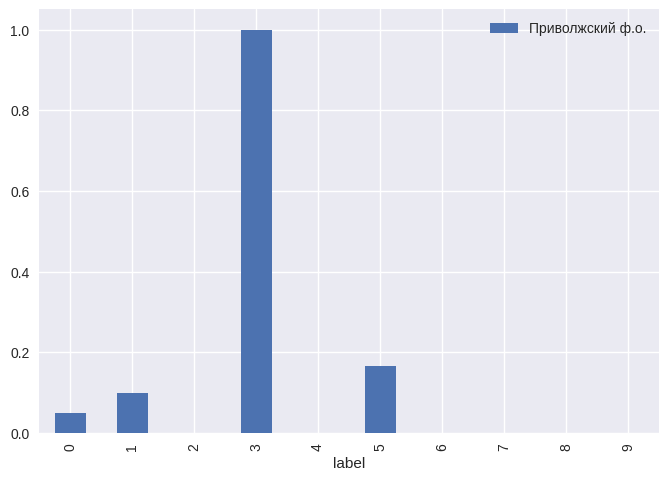

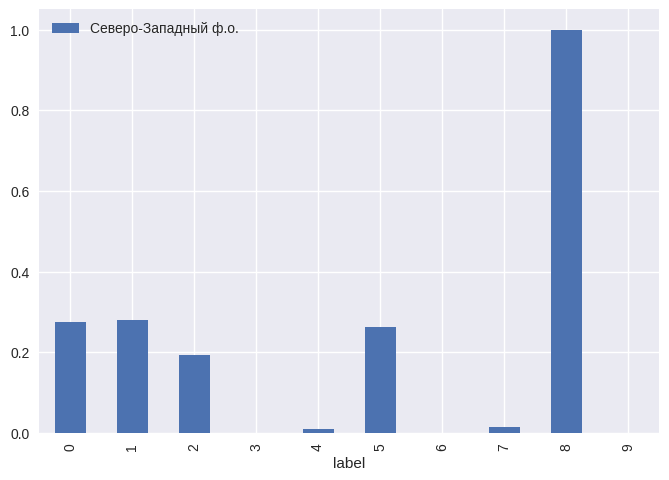

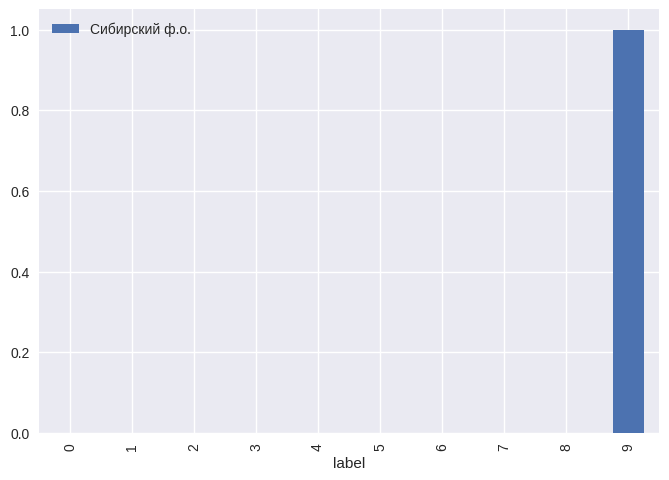

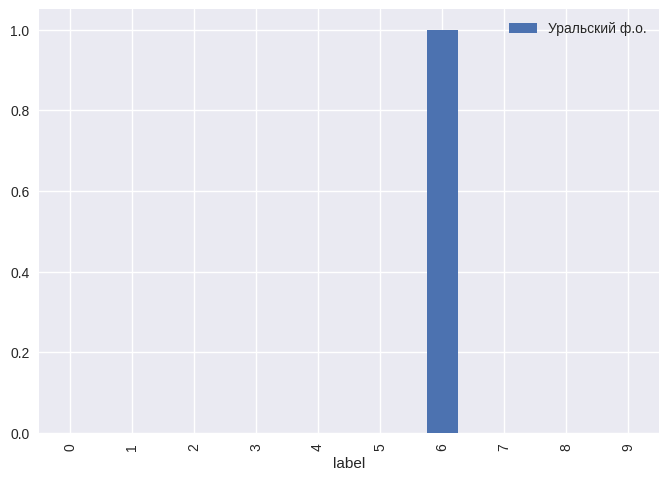

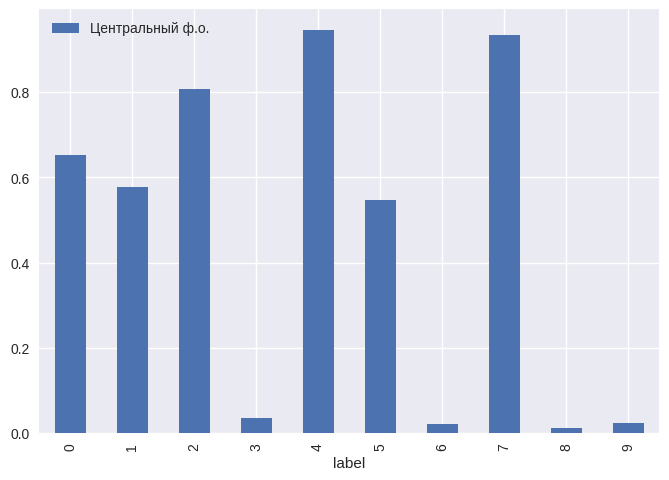

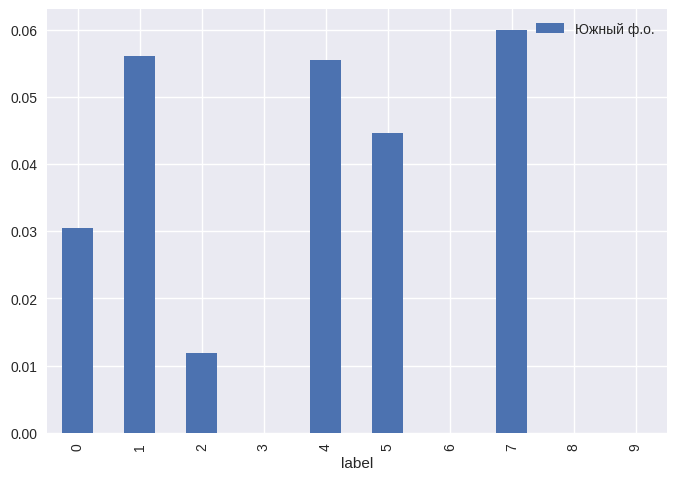

In [41]:
for col in cluster_df.columns:
    df_clients.groupby('label').mean().plot.bar(y=col)

In [42]:
# Оставим в выдаче только купиленные товары (отмененные не нужны)
df = df.loc[df['Status'] == 'Выдан клиенту']

tmp = df.groupby(['Phone_new', 'Order_ID', 'NomGroup'])['RowSum'].count().reset_index().groupby(['Phone_new', 'Order_ID'])['NomGroup'].count().reset_index()
phones = tmp.groupby('Phone_new')['Order_ID'].count()[tmp.groupby('Phone_new')['Order_ID'].count() > 2].index
df = df[df['Phone_new'].isin(phones)]

# Построение рекомендаций

In [43]:
df_rec = df.copy()
df_rec['datetime'] = pd.to_datetime(df_rec['OrderDate'] + ' ' + df_rec['время'])
df_rec['value'] = 1

In [44]:
last = df_rec.groupby('Phone_new')['datetime'].max().reset_index().set_index(['Phone_new', 'datetime'])
last_orders = df_rec.join(last, on=['Phone_new', 'datetime'], how='inner')
prev_orders = df_rec[~df_rec.index.isin(last_orders.index)]

In [45]:
from sklearn.model_selection import train_test_split


last_train, last_test = train_test_split(last_orders['Order_ID'].unique(), test_size=0.25, shuffle=True, random_state=8)

df_train = prev_orders.append(last_orders[last_orders['Order_ID'].isin(last_train)])
df_test = last_orders[last_orders['Order_ID'].isin(last_test)]

In [46]:
df_train = df_train.groupby(['Phone_new', 'NomGroup'])['value'].mean().reset_index()
df_test = df_test.groupby(['Phone_new', 'NomGroup'])['value'].mean().reset_index()

In [47]:
IDs_user = {y: x for x, y in enumerate(set(df_train['Phone_new']))}
IDs_item = {y: x for x, y in enumerate(set(df_train['NomGroup']))}

df_train['Phone_new'] = df_train['Phone_new'].map(IDs_user)
df_train['NomGroup'] = df_train['NomGroup'].map(IDs_item)
df_train.columns = ['user_id', 'item_id', 'value']

df_test['Phone_new'] = df_test['Phone_new'].map(IDs_user)
df_test['NomGroup'] = df_test['NomGroup'].map(IDs_item)
df_test.columns = ['user_id', 'item_id', 'value']
df_test

,user_id,item_id,value
0,970,91.0,1.0
1,508,385.0,1.0
2,763,399.0,1.0
3,156,346.0,1.0
4,522,73.0,1.0
...,...,...,...
291,446,213.0,1.0
292,494,284.0,1.0
293,473,399.0,1.0
294,1014,127.0,1.0


In [48]:
uid = list(set(df_train['user_id']))
iid = list(set(df_train['item_id']))

X_train = pd.DataFrame({'user_id' : sorted(uid * len(iid)), 'item_id' : iid * len(uid)})
X_train = X_train.join(df_train.set_index(['user_id', 'item_id']), on=['user_id', 'item_id'], how='outer', rsuffix='_').fillna(0.0)

uid = list(set(df_test['user_id']))
X_test = pd.DataFrame({'user_id' : sorted(uid * len(iid)), 'item_id' : iid * len(uid)})
X_test = X_test.join(df_test.set_index(['user_id', 'item_id']), on=['user_id', 'item_id'], how='outer', rsuffix='_').fillna(0.0)

In [49]:
clusters = df[['Phone_new', 'label']]
clusters['Phone_new'] = clusters['Phone_new'].map(IDs_user)
clusters = clusters.dropna()

X_train = X_train.set_index('user_id').join(clusters.set_index('Phone_new')).reset_index().dropna().rename(columns={"index": "user_id"})
X_test = X_test.set_index('user_id').join(clusters.set_index('Phone_new')).reset_index().dropna().rename(columns={"index": "user_id"})

In [50]:
print(X_train.shape, X_test.shape)

(2241120, 4) (559584, 4)


In [51]:
print('\tTrain\tTest')
for i in range(10):
    print(f"{i}\t{len(X_train[(X_train['label'] == i) & (X_train['value'] > 0)])}\t{len(X_test[(X_test['label'] == i) & (X_test['value'] > 0)])}")

	Train	Test
0	5886	234
1	959	85
2	2133	181
3	1024	96
4	2234	264
5	956	124
6	176	12
7	1758	141
8	2604	212
9	302	12


## Базовые методы колаборативной фильтрации

In [ ]:
# !pip install surprise

In [53]:
from surprise import Reader, Dataset


reader = Reader(rating_scale=(0, 1))
data_train = Dataset.load_from_df(X_train[['user_id', 'item_id', 'value']], reader).build_full_trainset()
data_test = Dataset.load_from_df(X_test[['user_id', 'item_id', 'value']], reader).build_full_trainset().build_testset()

In [54]:
from surprise import accuracy, Dataset, SVD, SVDpp, NMF, SlopeOne, NormalPredictor, CoClustering, KNNWithMeans
from surprise.model_selection import train_test_split


algo = SVD(n_factors=20, n_epochs=20, lr_all=0.01, reg_all=0.01, verbose=False)
algo.fit(data_train)
SVD_pred = algo.test(data_test)
print('SVD')
accuracy.rmse(SVD_pred)
accuracy.mae(SVD_pred)
print()

algo = NMF(n_factors=20, n_epochs=20, reg_pu=0.01, reg_qi=0.01, reg_bu=0.01, reg_bi=0.01, lr_bu=0.01, lr_bi=0.01, verbose=False)
algo.fit(data_train)
NMF_pred = algo.test(data_test)
print('NMF')
accuracy.rmse(NMF_pred)
accuracy.mae(NMF_pred)
print()

algo = SlopeOne()
algo.fit(data_train)
SlopeOne_pred = algo.test(data_test)
print('Slope One')
accuracy.rmse(SlopeOne_pred)
accuracy.mae(SlopeOne_pred)
print()

algo = CoClustering(n_cltr_u=5, n_cltr_i=5, n_epochs=10, verbose=False)
algo.fit(data_train)
CoClustering_pred = algo.test(data_test)
print('Co-clustering')
accuracy.rmse(CoClustering_pred)
accuracy.mae(CoClustering_pred)
print()

algo = NormalPredictor()
algo.fit(data_train)
RandNorm_pred = algo.test(data_test)
print('Random')
accuracy.rmse(RandNorm_pred)
accuracy.mae(RandNorm_pred)
print()

SVD
RMSE: 0.0529
MAE:  0.0114

NMF
RMSE: 0.0508
MAE:  0.0047

Slope One
RMSE: 0.0544
MAE:  0.0108

Co-clustering
RMSE: 0.0531
MAE:  0.0091

Random
RMSE: 0.0826
MAE:  0.0420



In [55]:
from sklearn.metrics import average_precision_score


def get_df(pred):
    return pd.DataFrame({'user' : [p.uid for p in pred], 'item' : [p.iid for p in pred], 'value' : [p.r_ui for p in pred], 'pred' : [p.est for p in pred]})


def map_k(data):
    ap = []
    for i in tqdm(set(data['user'])):
        ap += [average_precision_score(data[data['user'] == i]['value'], data[data['user'] == i]['pred'])]
    return np.mean(ap)

In [56]:
res = pd.DataFrame({
    'Segment': 'ALL',
    'Random': [map_k(get_df(RandNorm_pred))],
    'SVD': [map_k(get_df(SVD_pred))],
    'NMF': [map_k(get_df(NMF_pred))],
    'Slope One': [map_k(get_df(SlopeOne_pred))],
    'Co-clustering': [map_k(get_df(CoClustering_pred))],
    'Train size': [len(X_train[X_train['value'] > 0])],
    'Test size': [len(X_test[X_test['value'] > 0])],
    'Count users': [X_train['user_id'].nunique()],
    'Count users test': [X_test['user_id'].nunique()]
})

res

100%|██████████| 271/271 [00:01<00:00, 254.18it/s]


,Segment,Random,SVD,NMF,Slope One,Co-clustering,Train size,Test size,Count users,Count users test
0,ALL,0.006114,0.130323,0.09497,0.074135,0.131637,18032,1361,1081,271


## Рекомендации по сегментам

In [57]:
# !pip install surprise

In [58]:
from sklearn.metrics import average_precision_score


def get_df(pred):
    return pd.DataFrame({'user' : [p.uid for p in pred], 'item' : [p.iid for p in pred], 'value' : [p.r_ui for p in pred], 'pred' : [p.est for p in pred]})


def map_k(data):
    ap = []
    for i in tqdm(set(data['user'])):
        ap += [average_precision_score(data[data['user'] == i]['value'], data[data['user'] == i]['pred'])]
    return np.mean(ap)

In [59]:
from surprise import Reader, Dataset
from surprise import accuracy, Dataset, SVD, SVDpp, NMF, SlopeOne, NormalPredictor, CoClustering, KNNWithMeans
from surprise.model_selection import train_test_split


def seg_rec(c):
    reader = Reader(rating_scale=(0, 1))
    data_train = Dataset.load_from_df(X_train[X_train['label'] == c][['user_id', 'item_id', 'value']], reader).build_full_trainset()
    data_test = Dataset.load_from_df(X_test[X_test['label'] == c][['user_id', 'item_id', 'value']], reader).build_full_trainset().build_testset()


    algo = SVD(n_factors=20, n_epochs=20, lr_all=0.01, reg_all=0.01, verbose=False)
    algo.fit(data_train)
    SVD_pred = algo.test(data_test)
    print('SVD')
    accuracy.rmse(SVD_pred)
    accuracy.mae(SVD_pred)
    print()

    algo = NMF(n_factors=20, n_epochs=20, reg_pu=0.01, reg_qi=0.01, reg_bu=0.01, reg_bi=0.01, lr_bu=0.01, lr_bi=0.01, verbose=False)
    algo.fit(data_train)
    NMF_pred = algo.test(data_test)
    print('NMF')
    accuracy.rmse(NMF_pred)
    accuracy.mae(NMF_pred)
    print()

    algo = SlopeOne()
    algo.fit(data_train)
    SlopeOne_pred = algo.test(data_test)
    print('Slope One')
    accuracy.rmse(SlopeOne_pred)
    accuracy.mae(SlopeOne_pred)
    print()

    algo = CoClustering(n_cltr_u=5, n_cltr_i=5, n_epochs=10, verbose=False)
    algo.fit(data_train)
    CoClustering_pred = algo.test(data_test)
    print('Co-clustering')
    accuracy.rmse(CoClustering_pred)
    accuracy.mae(CoClustering_pred)
    print()

    algo = NormalPredictor()
    algo.fit(data_train)
    RandNorm_pred = algo.test(data_test)
    print('Random')
    accuracy.rmse(RandNorm_pred)
    accuracy.mae(RandNorm_pred)
    print()


    return [
        c,
        map_k(get_df(RandNorm_pred)),
        map_k(get_df(SVD_pred)),
        map_k(get_df(NMF_pred)),
        map_k(get_df(SlopeOne_pred)),
        map_k(get_df(CoClustering_pred)),
        len(X_train[(X_train['label'] == c) & (X_train['value'] > 0)]),
        len(X_test[(X_test['label'] == c) & (X_test['value'] > 0)]),
        X_train[X_train['label'] == c]['user_id'].nunique(),
        X_test[X_test['label'] == c]['user_id'].nunique()
    ]


res_seg = res.copy()
for i in set(X_train['label']):
    res_seg.loc[len(res_seg)] = seg_rec(i)
res_seg

SVD
RMSE: 0.0642
MAE:  0.0162

NMF
RMSE: 0.0614
MAE:  0.0097

Slope One
RMSE: 0.0687
MAE:  0.0167

Co-clustering
RMSE: 0.0638
MAE:  0.0140

Random
RMSE: 0.1013
MAE:  0.0552



100%|██████████| 24/24 [00:00<00:00, 295.89it/s]


SVD
RMSE: 0.0529
MAE:  0.0111

NMF
RMSE: 0.0538
MAE:  0.0060

Slope One
RMSE: 0.0527
MAE:  0.0094

Co-clustering
RMSE: 0.0545
MAE:  0.0096

Random
RMSE: 0.0798
MAE:  0.0395



100%|██████████| 16/16 [00:00<00:00, 396.47it/s]


SVD
RMSE: 0.0505
MAE:  0.0083

NMF
RMSE: 0.0503
MAE:  0.0057

Slope One
RMSE: 0.0510
MAE:  0.0093

Co-clustering
RMSE: 0.0550
MAE:  0.0091

Random
RMSE: 0.0791
MAE:  0.0391



100%|██████████| 40/40 [00:00<00:00, 415.14it/s]


SVD
RMSE: 0.0491
MAE:  0.0107

NMF
RMSE: 0.0477
MAE:  0.0043

Slope One
RMSE: 0.0493
MAE:  0.0087

Co-clustering
RMSE: 0.0565
MAE:  0.0082

Random
RMSE: 0.0753
MAE:  0.0376



100%|██████████| 20/20 [00:00<00:00, 212.24it/s]


SVD
RMSE: 0.0505
MAE:  0.0090

NMF
RMSE: 0.0490
MAE:  0.0036

Slope One
RMSE: 0.0500
MAE:  0.0083

Co-clustering
RMSE: 0.0507
MAE:  0.0084

Random
RMSE: 0.0758
MAE:  0.0367



100%|██████████| 56/56 [00:00<00:00, 398.67it/s]


SVD
RMSE: 0.0559
MAE:  0.0139

NMF
RMSE: 0.0556
MAE:  0.0056

Slope One
RMSE: 0.0540
MAE:  0.0103

Co-clustering
RMSE: 0.0583
MAE:  0.0108

Random
RMSE: 0.0783
MAE:  0.0376



100%|██████████| 21/21 [00:00<00:00, 388.66it/s]


SVD
RMSE: 0.0514
MAE:  0.0098

NMF
RMSE: 0.0561
MAE:  0.0049

Slope One
RMSE: 0.0528
MAE:  0.0085

Co-clustering
RMSE: 0.0637
MAE:  0.0093

Random
RMSE: 0.0742
MAE:  0.0357



100%|██████████| 3/3 [00:00<00:00, 223.97it/s]


SVD
RMSE: 0.0525
MAE:  0.0118

NMF
RMSE: 0.0489
MAE:  0.0059

Slope One
RMSE: 0.0534
MAE:  0.0099

Co-clustering
RMSE: 0.0555
MAE:  0.0090

Random
RMSE: 0.0788
MAE:  0.0397



100%|██████████| 33/33 [00:00<00:00, 436.35it/s]


SVD
RMSE: 0.0504
MAE:  0.0109

NMF
RMSE: 0.0485
MAE:  0.0042

Slope One
RMSE: 0.0504
MAE:  0.0088

Co-clustering
RMSE: 0.0525
MAE:  0.0086

Random
RMSE: 0.0775
MAE:  0.0384



100%|██████████| 54/54 [00:00<00:00, 382.05it/s]


SVD
RMSE: 0.0516
MAE:  0.0101

NMF
RMSE: 0.0477
MAE:  0.0031

Slope One
RMSE: 0.0521
MAE:  0.0088

Co-clustering
RMSE: 0.0540
MAE:  0.0082

Random
RMSE: 0.0763
MAE:  0.0382



100%|██████████| 4/4 [00:00<00:00, 272.02it/s]


,Segment,Random,SVD,NMF,Slope One,Co-clustering,Train size,Test size,Count users,Count users test
0,ALL,0.006114,0.130323,0.094970,0.074135,0.131637,18032.0,1361.0,1081.0,271.0
1,0.0,0.003732,0.125853,0.101663,0.056583,0.059119,5886.0,234.0,103.0,24.0
2,1.0,0.006256,0.211308,0.175181,0.199155,0.153822,959.0,85.0,75.0,16.0
3,2.0,0.004765,0.267258,0.226840,0.254844,0.222354,2133.0,181.0,159.0,40.0
4,3.0,0.004213,0.216225,0.285490,0.097538,0.233718,1024.0,96.0,79.0,20.0
5,4.0,0.009761,0.105094,0.192683,0.085322,0.124830,2234.0,264.0,200.0,56.0
6,5.0,0.003921,0.107499,0.082078,0.092651,0.093935,956.0,124.0,82.0,21.0
7,6.0,0.002024,0.035407,0.034770,0.009984,0.034770,176.0,12.0,15.0,3.0
8,7.0,0.004608,0.262034,0.312105,0.185190,0.223199,1758.0,141.0,130.0,33.0
9,8.0,0.007835,0.150164,0.174078,0.143767,0.165026,2604.0,212.0,210.0,54.0


In [60]:
res_seg.append(pd.DataFrame(
    [['ALL_SEG'] + list(res_seg.iloc[1:, 1:-4].mul(res_seg.iloc[1:]['Count users test'], axis=0).sum() / res_seg.iloc[0]['Count users test']) + [res_seg.iloc[0]['Train size'], res_seg.iloc[0]['Test size'], res_seg.iloc[0]['Count users'], res_seg.iloc[0]['Count users test']]], 
     columns=res_seg.columns
), ignore_index=True)

,Segment,Random,SVD,NMF,Slope One,Co-clustering,Train size,Test size,Count users,Count users test
0,ALL,0.006114,0.130323,0.094970,0.074135,0.131637,18032.0,1361.0,1081.0,271.0
1,0.0,0.003732,0.125853,0.101663,0.056583,0.059119,5886.0,234.0,103.0,24.0
2,1.0,0.006256,0.211308,0.175181,0.199155,0.153822,959.0,85.0,75.0,16.0
3,2.0,0.004765,0.267258,0.226840,0.254844,0.222354,2133.0,181.0,159.0,40.0
4,3.0,0.004213,0.216225,0.285490,0.097538,0.233718,1024.0,96.0,79.0,20.0
5,4.0,0.009761,0.105094,0.192683,0.085322,0.124830,2234.0,264.0,200.0,56.0
6,5.0,0.003921,0.107499,0.082078,0.092651,0.093935,956.0,124.0,82.0,21.0
7,6.0,0.002024,0.035407,0.034770,0.009984,0.034770,176.0,12.0,15.0,3.0
8,7.0,0.004608,0.262034,0.312105,0.185190,0.223199,1758.0,141.0,130.0,33.0
9,8.0,0.007835,0.150164,0.174078,0.143767,0.165026,2604.0,212.0,210.0,54.0


# Sequential models

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Представим товары, как слова, а заказы как предложения. "Предложения" резделим токеном \<SEP\>

In [62]:
df['datetime'] = pd.to_datetime(df['OrderDate'] + ' ' + df['время'])
df_seq = df.groupby(['Phone_new', 'datetime',  'Order_ID'])['NomGroup'].apply(lambda x: list(x)).reset_index()
df_seq = df_seq.groupby(['Phone_new'])[['datetime', 'NomGroup']].apply(lambda x: [['<CLS>']] + [v + ['<SEP>'] for v in x.sort_values(by=['datetime'])['NomGroup']]).reset_index()
df_seq[0] = df_seq[0].apply(lambda x: [product for order in x for product in order][:-1])
df_seq.columns = ['Phone_new', 'orders']
df_seq['last_sep'] = df_seq['orders'].apply(lambda x: len(x) - x[::-1].index('<SEP>') - 1)

In [63]:
# Токенизируем
product2num = {v: i + 5 for i, v in enumerate(set(df['NomGroup']))}
product2num['<PAD>'] = 0
product2num['<CLS>'] = 1
product2num['<SEP>'] = 2
product2num['<UNK>'] = 3
product2num['<MASK>'] = 4
num2tk = {v: k for k, v in product2num.items()}

df_seq['tokens'] = df_seq['orders'].apply(lambda x: [product2num[i] for i in x])

In [64]:
# Возьмем последний заказ за целевую переменную
X = []
y = []
for i in range(len(df_seq)):
    X += [df_seq['tokens'].iloc[i][:df_seq['last_sep'].iloc[i] + 1]]   
    y += [df_seq['tokens'].iloc[i][df_seq['last_sep'].iloc[i] + 1:]]
df_seq['X'] = X
df_seq['y'] = y

In [65]:
# Добавим сегменты
df_seq = df_seq.join(df[['Phone_new', 'label']].groupby('Phone_new').max(), on='Phone_new', how='inner')
df_seq

,Phone_new,orders,last_sep,tokens,X,y,label
0,55555555-51535356545777,"[<CLS>, Кронштейны для телевизоров, <SEP>, 3D...",4,"[1, 205, 2, 187, 2, 386]","[1, 205, 2, 187, 2]",[386],7
1,55574848-485051575051755,"[<CLS>, Внешние жесткие диски, <SEP>, Подставк...",8,"[1, 330, 2, 220, 2, 20, 2, 79, 2, 100]","[1, 330, 2, 220, 2, 20, 2, 79, 2]",[100],8
2,55574848-50565454514879,"[<CLS>, Утюги, <SEP>, Стиральные машины, <SEP>...",20,"[1, 251, 2, 186, 2, 137, 2, 186, 2, 456, 2, 14...","[1, 251, 2, 186, 2, 137, 2, 186, 2, 456, 2, 14...","[275, 80]",0
3,55574848-515049575152715,"[<CLS>, Блендеры, <SEP>, Велосипеды, <SEP>, Ве...",4,"[1, 421, 2, 335, 2, 335]","[1, 421, 2, 335, 2]",[335],8
4,55574848-515450495555755,"[<CLS>, Крепления для беговых лыж, <SEP>, Бего...",6,"[1, 403, 2, 412, 403, 5, 2, 403]","[1, 403, 2, 412, 403, 5, 2]",[403],8
...,...,...,...,...,...,...,...
1076,55575750-48485552565176,"[<CLS>, Грифы, Диски, <SEP>, Диски, Грифы, <SE...",6,"[1, 9, 29, 2, 29, 9, 2, 29]","[1, 9, 29, 2, 29, 9, 2]",[29],0
1077,55575750-50485152564871,"[<CLS>, Электрические духовые шкафы, Встраивае...",9,"[1, 150, 282, 144, 387, 153, 2, 387, 150, 2, 144]","[1, 150, 282, 144, 387, 153, 2, 387, 150, 2]",[144],3
1078,55575757-49545050495571,"[<CLS>, Холодильники, <SEP>, Аксессуары для са...",5,"[1, 137, 2, 217, 217, 2, 219]","[1, 137, 2, 217, 217, 2]",[219],3
1079,55575757-54545448494874,"[<CLS>, Машинки для стрижки волос, <SEP>, Для ...",5,"[1, 275, 2, 50, 103, 2, 146]","[1, 275, 2, 50, 103, 2]",[146],1


In [66]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_seq[['tokens', 'X', 'y', 'label']], test_size=0.25, shuffle=True, random_state=71)

In [67]:
MAX_SEQ_LEN = 200

In [68]:
from sklearn.metrics import average_precision_score


def map_score(y_true, y_pred):
    ap = []
    for i in range(len(y_true)):
        ap += [average_precision_score(y_true[i], y_pred[i])]
    return ap, np.mean(ap)


def mean_precision_k(y_true, y_pred, k=3):
    res = []
    for i in range(len(y_true)):
        top = y_true[i][np.argsort(y_pred[i])][::-1][:k]
        res += [top.sum() / k]
    return res, np.mean(res)


def mean_recall_k(y_true, y_pred, k=3):
    res = []
    for i in range(len(y_true)):
        top = y_true[i][np.argsort(y_pred[i])][::-1][:k]
        res += [top.sum() / y_true[i].sum()]
    return res, np.mean(res)


def mean_f1_k(y_true, y_pred, k=3):
    p, _ = mean_precision_k(y_true, y_pred, k)
    r, _ = mean_recall_k(y_true, y_pred, k)
    p = np.array(p)
    r = np.array(r)
    z = (p + r == 0).astype(int)
    res = list((2 * p * r / (p + r + z)))
    return res, np.mean(res)

## GRU4Rec

In [69]:
def split_array(arr, value):
    result = []
    sublist = []
    for num in arr:
        if num == value:
            if sublist:
                result.append(sublist)
                sublist = []
        else:
            sublist.append(num)
    if sublist:
        result.append(sublist)
    return result


def orders(arr):
    result = []
    for basket in arr:
        z = np.zeros(len(product2num))
        z[basket] = 1
        result += [z]
    return np.array(result)

In [70]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, batch_size):
        df = data.copy()
        df['tokens'] = df['tokens'].apply(lambda x: [1] + x[1 - MAX_SEQ_LEN:] if len(x) > MAX_SEQ_LEN else x)
        df['tokens'] = df['tokens'].apply(lambda x: split_array(x, product2num['<SEP>']))
        self.batches = []
        df['sz'] = df['tokens'].apply(lambda x: len(x))
        df = df.sort_values(by=['sz'], ascending=False)
        for i in range(len(df)):
            if i % batch_size != 0:
                Z = np.zeros((len(self.batches[-1][0]), len(product2num)))
                seq = orders(df['tokens'].iloc[i])
                Z[:len(seq)] = seq
                self.batches[-1] += [Z[:, 5:].tolist()]
            else:
                Z = orders(df['tokens'].iloc[i])
                self.batches += [[Z[:, 5:].tolist()]]
        
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, idx):
        vecs = np.array(self.batches[idx])
        pad = np.array(self.batches[idx]).max(axis=2) == 0
        return vecs[:, :-1, :], vecs[:, 1:, :], pad[:, 1:]

In [73]:
BATCH_SIZE = 32

train_dataset = Dataset(df_train, batch_size=BATCH_SIZE)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = Dataset(df_test, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

### Train

In [74]:
from GRU4Rec import GRU4Rec


model = GRU4Rec(
    num_items= len(product2num)-5,
    embed_size=32,
    num_blocks=4,
    d_ff=128,
    output_sz=len(product2num)-5,
    dropout_prob=0.1
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #, weight_decay=0.01
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

GRU4Rec(
  (gru): GRU(478, 32, num_layers=4, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=478, bias=True)
)

In [75]:
from sklearn.metrics import average_precision_score


EPOCHS = 30

best_epoch = 0
best_map = 0
best_f1_3 = 0
best_f1_5 = 0
best_f1_10 = 0
for n in range(EPOCHS):
    model.train()
    ap = []
    f1_3 = []
    f1_5 = []
    f1_10 = []
    pbar = tqdm(train_dataloader, desc=f'Train epoch {n + 1}')
    for X, y, pad in pbar:
        X, y, pad = X[0], y[0], pad[0]

        optimizer.zero_grad()
        # строим предсказания
        pred, _ = model(X.float().to(device))

        # считаем ошибку и корректируем веса
        last = torch.zeros((pad.shape[0], pad.shape[1] + 1)) == 0
        last[:, :-1] = pad
        last[:, :-1] ^= last[:, 1:]
        last = last[:, :-1]
        
        loss = criterion(pred[last], y[last].to(device))
        loss.backward()
        optimizer.step()

        # сохраняем результаты для рассчета метрик
        y_true, y_pred = y[last].cpu().detach().numpy(), pred[last].cpu().detach().numpy()

        batch_ap, batch_map = map_score(y_true, y_pred)
        ap += batch_ap

        batch_f1_3, batch_mf1_3 = mean_f1_k(y_true, y_pred, k=3)
        batch_f1_5, batch_mf1_5 = mean_f1_k(y_true, y_pred, k=5)
        batch_f1_10, batch_mf1_10 = mean_f1_k(y_true, y_pred, k=10)
        f1_3 += batch_f1_3
        f1_5 += batch_f1_5
        f1_10 += batch_f1_10

        pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap), 'f1@3': np.mean(f1_3), 'f1@5': np.mean(f1_5), 'f1@10': np.mean(f1_10)})
    

    model.eval()
    with torch.no_grad():
        ap = []
        f1_3 = []
        f1_5 = []
        f1_10 = []
        pbar = tqdm(test_dataloader, desc=f'Test epoch {n + 1}')
        for X, y, pad in pbar:
            X, y, pad = X[0], y[0], pad[0]

            # строим предсказания
            pred, _ = model(X.float().to(device))

            # сохраняем результаты для рассчета метрик
            last = torch.zeros((pad.shape[0], pad.shape[1] + 1)) == 0
            last[:, :-1] = pad
            last[:, :-1] ^= last[:, 1:]
            last = last[:, :-1]

            y_true, y_pred = y[last].cpu().detach().numpy(), pred[last].cpu().detach().numpy()

            batch_ap, batch_map = map_score(y_true, y_pred)
            ap += batch_ap

            batch_f1_3, batch_mf1_3 = mean_f1_k(y_true, y_pred, k=3)
            batch_f1_5, batch_mf1_5 = mean_f1_k(y_true, y_pred, k=5)
            batch_f1_10, batch_mf1_10 = mean_f1_k(y_true, y_pred, k=10)
            f1_3 += batch_f1_3
            f1_5 += batch_f1_5
            f1_10 += batch_f1_10

            pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap), 'f1@3': np.mean(f1_3), 'f1@5': np.mean(f1_5), 'f1@10': np.mean(f1_10)})

        if best_map < np.mean(ap):
            best_epoch = n + 1
            best_map = np.mean(ap)
            best_f1_3 = np.mean(f1_3)
            best_f1_5 = np.mean(f1_5)
            best_f1_10 = np.mean(f1_10)
    
    print()

print('\nBest epoch:', best_epoch)
print('MAP =', best_map)
print('f1@3 =', best_f1_3)
print('f1@5 =', best_f1_5)
print('f1@10 =', best_f1_10)

Test epoch 1: 100%|██████████| 9/9 [00:00<00:00, 19.57it/s, loss=7.02, batch_map=0.145, map=0.0926, f1@3=0.0454, f1@5=0.039, f1@10=0.0327]


Test epoch 2: 100%|██████████| 9/9 [00:00<00:00, 19.10it/s, loss=6.02, batch_map=0.114, map=0.113, f1@3=0.0601, f1@5=0.0542, f1@10=0.0392]


Test epoch 3: 100%|██████████| 9/9 [00:00<00:00, 13.78it/s, loss=6.17, batch_map=0.172, map=0.121, f1@3=0.0601, f1@5=0.0614, f1@10=0.0571]


Test epoch 4: 100%|██████████| 9/9 [00:00<00:00, 13.51it/s, loss=6.04, batch_map=0.169, map=0.134, f1@3=0.069, f1@5=0.0625, f1@10=0.0518]


Test epoch 5: 100%|██████████| 9/9 [00:00<00:00, 20.06it/s, loss=5.54, batch_map=0.0654, map=0.13, f1@3=0.0601, f1@5=0.0625, f1@10=0.0525]


Test epoch 6: 100%|██████████| 9/9 [00:00<00:00, 20.09it/s, loss=5.96, batch_map=0.0869, map=0.115, f1@3=0.0601, f1@5=0.0625, f1@10=0.0552]


Test epoch 7: 100%|██████████| 9/9 [00:00<00:00, 18.80it/s, loss=4.98, batch_map=0.0635, map=0.128, f1@3=0.062, f1@5=0.0627, f1@10=0.0504]


Test epoch 8: 100%|██████████| 9/9 [00:00<00:00, 19.32it/s, loss=5.24, batch_map=0.138, map=0.112, f1@3=0.0601, f1@5=0.0625, f1@10=0.0551]


Test epoch 9: 100%|██████████| 9/9 [00:00<00:00, 19.70it/s, loss=5.18, batch_map=0.136, map=0.12, f1@3=0.0601, f1@5=0.0637, f1@10=0.0564]


Test epoch 10: 100%|██████████| 9/9 [00:00<00:00, 12.70it/s, loss=5.8, batch_map=0.0936, map=0.12, f1@3=0.0579, f1@5=0.0602, f1@10=0.0497]


Test epoch 11: 100%|██████████| 9/9 [00:00<00:00, 13.88it/s, loss=5.45, batch_map=0.115, map=0.11, f1@3=0.0487, f1@5=0.0637, f1@10=0.0578]


Test epoch 12: 100%|██████████| 9/9 [00:00<00:00, 18.95it/s, loss=5.48, batch_map=0.09, map=0.112, f1@3=0.0542, f1@5=0.0599, f1@10=0.0571]


Test epoch 13: 100%|██████████| 9/9 [00:00<00:00, 19.33it/s, loss=5.39, batch_map=0.0866, map=0.125, f1@3=0.0664, f1@5=0.0621, f1@10=0.0571]


Test epoch 14: 100%|██████████| 9/9 [00:00<00:00, 18.53it/s, loss=4.2, batch_map=0.0875, map=0.117, f1@3=0.0605, f1@5=0.0662, f1@10=0.0543]


Test epoch 15: 100%|██████████| 9/9 [00:00<00:00, 18.07it/s, loss=4.39, batch_map=0.123, map=0.117, f1@3=0.0631, f1@5=0.0644, f1@10=0.0557]


Test epoch 16: 100%|██████████| 9/9 [00:00<00:00, 12.35it/s, loss=5.04, batch_map=0.11, map=0.117, f1@3=0.0664, f1@5=0.0699, f1@10=0.059]


Test epoch 17: 100%|██████████| 9/9 [00:00<00:00, 12.42it/s, loss=4.04, batch_map=0.0599, map=0.112, f1@3=0.0458, f1@5=0.0451, f1@10=0.053]


Test epoch 18: 100%|██████████| 9/9 [00:00<00:00, 20.10it/s, loss=5.08, batch_map=0.125, map=0.122, f1@3=0.0668, f1@5=0.0689, f1@10=0.053]


Test epoch 19: 100%|██████████| 9/9 [00:00<00:00, 19.66it/s, loss=4.31, batch_map=0.113, map=0.127, f1@3=0.072, f1@5=0.0646, f1@10=0.0531]


Test epoch 20: 100%|██████████| 9/9 [00:00<00:00, 19.55it/s, loss=5.49, batch_map=0.124, map=0.129, f1@3=0.0753, f1@5=0.0736, f1@10=0.0578]


Test epoch 21: 100%|██████████| 9/9 [00:00<00:00, 19.46it/s, loss=4.86, batch_map=0.0894, map=0.127, f1@3=0.0742, f1@5=0.0738, f1@10=0.0584]


Test epoch 22: 100%|██████████| 9/9 [00:00<00:00, 19.77it/s, loss=4.47, batch_map=0.197, map=0.128, f1@3=0.0701, f1@5=0.0723, f1@10=0.0524]


Test epoch 23: 100%|██████████| 9/9 [00:00<00:00, 12.95it/s, loss=3.66, batch_map=0.114, map=0.124, f1@3=0.0686, f1@5=0.0689, f1@10=0.0584]


Test epoch 24: 100%|██████████| 9/9 [00:00<00:00, 17.39it/s, loss=4.61, batch_map=0.0906, map=0.137, f1@3=0.0779, f1@5=0.0691, f1@10=0.0578]


Test epoch 25: 100%|██████████| 9/9 [00:00<00:00, 19.50it/s, loss=4.05, batch_map=0.174, map=0.121, f1@3=0.0683, f1@5=0.0672, f1@10=0.0564]


Test epoch 26: 100%|██████████| 9/9 [00:00<00:00, 19.92it/s, loss=4.83, batch_map=0.0789, map=0.141, f1@3=0.0745, f1@5=0.0715, f1@10=0.059]


Test epoch 27: 100%|██████████| 9/9 [00:00<00:00, 17.56it/s, loss=4.8, batch_map=0.124, map=0.125, f1@3=0.0668, f1@5=0.0723, f1@10=0.0538]


Test epoch 28: 100%|██████████| 9/9 [00:00<00:00, 19.67it/s, loss=3.68, batch_map=0.0734, map=0.128, f1@3=0.0686, f1@5=0.0627, f1@10=0.0571]


Test epoch 29: 100%|██████████| 9/9 [00:00<00:00, 13.00it/s, loss=3.82, batch_map=0.153, map=0.127, f1@3=0.0738, f1@5=0.0736, f1@10=0.0544]


Test epoch 30: 100%|██████████| 9/9 [00:00<00:00, 13.00it/s, loss=4.39, batch_map=0.201, map=0.132, f1@3=0.0686, f1@5=0.0691, f1@10=0.0591]



Best epoch: 26
MAP = 0.14075016076318844
f1@3 = 0.07453874538745389
f1@5 = 0.07151642945000879
f1@10 = 0.059008642034472286


## SASRec

In [76]:
def split_array(arr, value):
    result = []
    sublist = []
    for num in arr:
        if num == value:
            if sublist:
                result.append(sublist)
                sublist = []
        else:
            sublist.append(num)
    if sublist:
        result.append(sublist)
    return result


def orders(arr):
    result = []
    for basket in arr:
        z = np.zeros(len(product2num))
        z[basket] = 1
        result += [z]
    return np.array(result)

In [77]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, batch_size):
        df = data.copy()
        df['tokens'] = df['tokens'].apply(lambda x: [1] + x[1 - MAX_SEQ_LEN:] if len(x) > MAX_SEQ_LEN else x)
        df['tokens'] = df['tokens'].apply(lambda x: split_array(x, product2num['<SEP>']))
        self.batches = []
        df['sz'] = df['tokens'].apply(lambda x: len(x))
        df = df.sort_values(by=['sz'], ascending=False)
        for i in range(len(df)):
            if i % batch_size != 0:
                Z = np.zeros((len(self.batches[-1][0]), len(product2num)))
                seq = orders(df['tokens'].iloc[i])
                Z[:len(seq)] = seq
                self.batches[-1] += [Z[:, 5:].tolist()]
            else:
                Z = orders(df['tokens'].iloc[i])
                self.batches += [[Z[:, 5:].tolist()]]
        
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, idx):
        vecs = np.array(self.batches[idx])
        pad = np.array(self.batches[idx]).max(axis=2) == 0
        return vecs[:, :-1, :], vecs[:, 1:, :], pad[:, 1:]

In [78]:
BATCH_SIZE = 32

train_dataset = Dataset(df_train, batch_size=BATCH_SIZE)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = Dataset(df_test, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

### Train

In [79]:
from SASRec import SASRec


model = SASRec(
    num_items= len(product2num)-5,
    embed_size=128,
    max_seq_length=MAX_SEQ_LEN,
    num_heads=4,
    num_blocks=4,
    d_ff=256,
    output_sz=len(product2num)-5,
    dropout_prob=0.1
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #, weight_decay=0.01
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

SASRec(
  (item_embedding): Linear(in_features=478, out_features=128, bias=True)
  (positional_embedding): Embedding(200, 128)
  (attention_blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (self_attention): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=128, out_features=478, bias=True)
)

In [80]:
from sklearn.metrics import average_precision_score


EPOCHS = 30

best_epoch = 0
best_map = 0
best_f1_3 = 0
best_f1_5 = 0
best_f1_10 = 0
for n in range(EPOCHS):
    model.train()
    ap = []
    f1_3 = []
    f1_5 = []
    f1_10 = []
    pbar = tqdm(train_dataloader, desc=f'Train epoch {n + 1}')
    for X, y, pad in pbar:
        X, y, pad = X[0], y[0], pad[0]

        optimizer.zero_grad()
        # строим предсказания
        pred = model(X.float().to(device))

        # считаем ошибку и корректируем веса
        loss = criterion(pred[~pad], y[~pad].to(device))
        loss.backward()
        optimizer.step()

        # сохраняем результаты для рассчета метрик
        last = torch.zeros((pad.shape[0], pad.shape[1] + 1)) == 0
        last[:, :-1] = pad
        last[:, :-1] ^= last[:, 1:]
        last = last[:, :-1]

        y_true, y_pred = y[last].cpu().detach().numpy(), pred[last].cpu().detach().numpy()

        batch_ap, batch_map = map_score(y_true, y_pred)
        ap += batch_ap

        batch_f1_3, batch_mf1_3 = mean_f1_k(y_true, y_pred, k=3)
        batch_f1_5, batch_mf1_5 = mean_f1_k(y_true, y_pred, k=5)
        batch_f1_10, batch_mf1_10 = mean_f1_k(y_true, y_pred, k=10)
        f1_3 += batch_f1_3
        f1_5 += batch_f1_5
        f1_10 += batch_f1_10

        pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap), 'f1@3': np.mean(f1_3), 'f1@5': np.mean(f1_5), 'f1@10': np.mean(f1_10)})
    

    model.eval()
    with torch.no_grad():
        ap = []
        f1_3 = []
        f1_5 = []
        f1_10 = []
        pbar = tqdm(test_dataloader, desc=f'Test epoch {n + 1}')
        for X, y, pad in pbar:
            X, y, pad = X[0], y[0], pad[0]

            # строим предсказания
            pred = model(X.float().to(device))

            # сохраняем результаты для рассчета метрик
            last = torch.zeros((pad.shape[0], pad.shape[1] + 1)) == 0
            last[:, :-1] = pad
            last[:, :-1] ^= last[:, 1:]
            last = last[:, :-1]

            y_true, y_pred = y[last].cpu().detach().numpy(), pred[last].cpu().detach().numpy()

            batch_ap, batch_map = map_score(y_true, y_pred)
            ap += batch_ap

            batch_f1_3, batch_mf1_3 = mean_f1_k(y_true, y_pred, k=3)
            batch_f1_5, batch_mf1_5 = mean_f1_k(y_true, y_pred, k=5)
            batch_f1_10, batch_mf1_10 = mean_f1_k(y_true, y_pred, k=10)
            f1_3 += batch_f1_3
            f1_5 += batch_f1_5
            f1_10 += batch_f1_10

            pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap), 'f1@3': np.mean(f1_3), 'f1@5': np.mean(f1_5), 'f1@10': np.mean(f1_10)})

        if best_map < np.mean(ap):
            best_epoch = n + 1
            best_map = np.mean(ap)
            best_f1_3 = np.mean(f1_3)
            best_f1_5 = np.mean(f1_5)
            best_f1_10 = np.mean(f1_10)
    
    print()

print('\nBest epoch:', best_epoch)
print('MAP =', best_map)
print('f1@3 =', best_f1_3)
print('f1@5 =', best_f1_5)
print('f1@10 =', best_f1_10)

Test epoch 1: 100%|██████████| 9/9 [00:00<00:00, 17.08it/s, loss=6.2, batch_map=0.0663, map=0.129, f1@3=0.0723, f1@5=0.0588, f1@10=0.0517]


Test epoch 2: 100%|██████████| 9/9 [00:00<00:00, 18.82it/s, loss=6.27, batch_map=0.127, map=0.125, f1@3=0.0554, f1@5=0.0549, f1@10=0.0564]


Test epoch 3: 100%|██████████| 9/9 [00:00<00:00, 16.70it/s, loss=5.34, batch_map=0.0912, map=0.123, f1@3=0.0512, f1@5=0.0599, f1@10=0.0571]


Test epoch 4: 100%|██████████| 9/9 [00:00<00:00, 13.23it/s, loss=6.29, batch_map=0.0415, map=0.0991, f1@3=0.0453, f1@5=0.0578, f1@10=0.055]


Test epoch 5: 100%|██████████| 9/9 [00:00<00:00, 11.57it/s, loss=5.51, batch_map=0.0671, map=0.0981, f1@3=0.0516, f1@5=0.0578, f1@10=0.0564]


Test epoch 6: 100%|██████████| 9/9 [00:00<00:00, 10.64it/s, loss=5.4, batch_map=0.125, map=0.124, f1@3=0.0579, f1@5=0.0545, f1@10=0.0557]


Test epoch 7: 100%|██████████| 9/9 [00:00<00:00, 18.73it/s, loss=5.18, batch_map=0.143, map=0.117, f1@3=0.0579, f1@5=0.0505, f1@10=0.0511]


Test epoch 8: 100%|██████████| 9/9 [00:00<00:00, 17.72it/s, loss=5.83, batch_map=0.108, map=0.108, f1@3=0.0524, f1@5=0.0522, f1@10=0.0444]


Test epoch 9: 100%|██████████| 9/9 [00:00<00:00, 17.32it/s, loss=5.78, batch_map=0.143, map=0.106, f1@3=0.0472, f1@5=0.051, f1@10=0.0538]


Test epoch 10: 100%|██████████| 9/9 [00:00<00:00, 12.74it/s, loss=6.31, batch_map=0.0955, map=0.104, f1@3=0.0494, f1@5=0.0528, f1@10=0.0524]


Test epoch 11: 100%|██████████| 9/9 [00:00<00:00, 11.91it/s, loss=5.14, batch_map=0.0921, map=0.112, f1@3=0.0491, f1@5=0.0534, f1@10=0.0512]


Test epoch 12: 100%|██████████| 9/9 [00:00<00:00, 17.80it/s, loss=5.46, batch_map=0.147, map=0.101, f1@3=0.0383, f1@5=0.0553, f1@10=0.0564]


Test epoch 13: 100%|██████████| 9/9 [00:00<00:00, 17.77it/s, loss=5.31, batch_map=0.0592, map=0.113, f1@3=0.0598, f1@5=0.0491, f1@10=0.051]


Test epoch 14: 100%|██████████| 9/9 [00:00<00:00, 18.13it/s, loss=5.89, batch_map=0.134, map=0.123, f1@3=0.0587, f1@5=0.0564, f1@10=0.057]


Test epoch 15: 100%|██████████| 9/9 [00:00<00:00, 17.29it/s, loss=4.15, batch_map=0.138, map=0.133, f1@3=0.0808, f1@5=0.0617, f1@10=0.0524]


Test epoch 16: 100%|██████████| 9/9 [00:00<00:00, 11.34it/s, loss=5.18, batch_map=0.118, map=0.159, f1@3=0.0827, f1@5=0.0824, f1@10=0.0585]


Test epoch 17: 100%|██████████| 9/9 [00:00<00:00, 17.10it/s, loss=4.37, batch_map=0.191, map=0.171, f1@3=0.0982, f1@5=0.0791, f1@10=0.0585]


Test epoch 18: 100%|██████████| 9/9 [00:00<00:00, 16.63it/s, loss=4.73, batch_map=0.161, map=0.169, f1@3=0.0941, f1@5=0.0775, f1@10=0.0591]


Test epoch 19: 100%|██████████| 9/9 [00:00<00:00, 17.43it/s, loss=3.93, batch_map=0.199, map=0.167, f1@3=0.0945, f1@5=0.0729, f1@10=0.0558]


Test epoch 20: 100%|██████████| 9/9 [00:00<00:00, 17.53it/s, loss=3.49, batch_map=0.171, map=0.187, f1@3=0.103, f1@5=0.0861, f1@10=0.0606]


Test epoch 21: 100%|██████████| 9/9 [00:00<00:00, 12.36it/s, loss=3.6, batch_map=0.25, map=0.171, f1@3=0.0923, f1@5=0.0787, f1@10=0.0512]


Test epoch 22: 100%|██████████| 9/9 [00:00<00:00, 17.36it/s, loss=4, batch_map=0.24, map=0.172, f1@3=0.0963, f1@5=0.0754, f1@10=0.0521]


Test epoch 23: 100%|██████████| 9/9 [00:00<00:00, 17.41it/s, loss=2.97, batch_map=0.166, map=0.177, f1@3=0.104, f1@5=0.0803, f1@10=0.054]


Test epoch 24: 100%|██████████| 9/9 [00:00<00:00, 16.44it/s, loss=2.4, batch_map=0.128, map=0.166, f1@3=0.0878, f1@5=0.0694, f1@10=0.0519]


Test epoch 25: 100%|██████████| 9/9 [00:00<00:00, 16.28it/s, loss=2.48, batch_map=0.208, map=0.166, f1@3=0.0963, f1@5=0.0682, f1@10=0.0479]


Test epoch 26: 100%|██████████| 9/9 [00:00<00:00, 11.83it/s, loss=3.55, batch_map=0.139, map=0.184, f1@3=0.0982, f1@5=0.0752, f1@10=0.0532]


Test epoch 27: 100%|██████████| 9/9 [00:00<00:00, 16.98it/s, loss=1.79, batch_map=0.219, map=0.176, f1@3=0.0915, f1@5=0.0733, f1@10=0.0505]


Test epoch 28: 100%|██████████| 9/9 [00:00<00:00, 18.10it/s, loss=1.94, batch_map=0.193, map=0.156, f1@3=0.0871, f1@5=0.0727, f1@10=0.0526]


Test epoch 29: 100%|██████████| 9/9 [00:00<00:00, 17.28it/s, loss=1.22, batch_map=0.233, map=0.156, f1@3=0.0941, f1@5=0.0717, f1@10=0.0518]


Test epoch 30: 100%|██████████| 9/9 [00:00<00:00, 16.58it/s, loss=2.71, batch_map=0.183, map=0.143, f1@3=0.0764, f1@5=0.0659, f1@10=0.0481]



Best epoch: 20
MAP = 0.1867413483416693
f1@3 = 0.1033210332103321
f1@5 = 0.0861008610086101
f1@10 = 0.060606060606060615


## BERT

In [87]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, batch_size):
        df = data.copy()
        df['X'] = df['X'].apply(lambda x: [1] + x[1 - MAX_SEQ_LEN:] if len(x) > MAX_SEQ_LEN else x)
        self.batches_X = []
        self.batches_y = []
        self.batches_seg = []
        df['sz'] = df['X'].apply(lambda x: len(x))
        df = df.sort_values(by=['sz'], ascending=False)
        for i in range(len(df)):
            z = np.zeros(len(product2num))
            z[df['y'].iloc[i]] = 1
            s = np.zeros(10)
            s[df['label'].iloc[i]] = 1
            if i % batch_size != 0:
                self.batches_X[-1] += [df['X'].iloc[i] + [0] * (len(self.batches_X[-1][0]) - len(df['X'].iloc[i]))]
                self.batches_y[-1] += [list(z[5:])]
                self.batches_seg[-1] += [list(s)]
            else:
                self.batches_X += [[df['X'].iloc[i]]]
                self.batches_y += [[list(z[5:])]]
                self.batches_seg += [[list(s)]]
        
    def __len__(self):
        return len(self.batches_X)
    
    def __getitem__(self, idx):
        return np.array(self.batches_X[idx]), np.array(self.batches_y[idx]), np.array(self.batches_X[idx]) == 0, np.array(self.batches_seg[idx])

In [88]:
BATCH_SIZE = 32

train_dataset = Dataset(df_train, batch_size=BATCH_SIZE)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = Dataset(df_test, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

### Train MLM

In [89]:
from proposed_model import TransformerEncoder



model = TransformerEncoder(
    vocab_size=len(product2num),
    d_model=128,
    num_heads=4,
    d_ff=256,
    num_layers=4,
    output_sz=len(product2num)-5,
    tokenizer=product2num,
    max_seq_length=MAX_SEQ_LEN
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #, weight_decay=0.01
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

TransformerEncoder(
  (embedding): Embedding(483, 128)
  (pos_enc): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=128, out_features=478, bias=True)
)

In [90]:
from sklearn.metrics import average_precision_score


EPOCHS = 30
MASK_P = 0.15

best_epoch = 0
best_map = 0
best_f1_3 = 0
best_f1_5 = 0
best_f1_10 = 0
for n in range(EPOCHS):
    model.train()
    ap = []
    f1_3 = []
    f1_5 = []
    f1_10 = []
    pbar = tqdm(train_dataloader, desc=f'Train epoch {n + 1}')
    for X, y, pad, _ in pbar:
        X, y, pad = X[0], y[0], pad[0]

        onehot_Y = torch.eye(len(product2num))[X][:, :, 5:]
        onehot_Y[:, 0, :] = y
        mask = (X > 4) & (torch.rand(X.shape) < MASK_P)
        masked_X = X.masked_fill(mask, product2num['<MASK>'])

        optimizer.zero_grad()
        # строим предсказания
        pred = model(masked_X.to(device), pad.to(device))

        # считаем ошибку и корректируем веса
        loss_cls = criterion(pred[:, 0, :], y.float().to(device))
        loss_mask = criterion(pred[mask], onehot_Y[mask].to(device))
        loss = loss_mask + loss_cls
        loss.backward()
        optimizer.step()

        # сохраняем результаты для рассчета метрик 
        y_true, y_pred = y.cpu().detach().numpy(), pred[:, 0, :].cpu().detach().numpy()

        batch_ap, batch_map = map_score(y_true, y_pred)
        ap += batch_ap

        batch_f1_3, batch_mf1_3 = mean_f1_k(y_true, y_pred, k=3)
        batch_f1_5, batch_mf1_5 = mean_f1_k(y_true, y_pred, k=5)
        batch_f1_10, batch_mf1_10 = mean_f1_k(y_true, y_pred, k=10)
        f1_3 += batch_f1_3
        f1_5 += batch_f1_5
        f1_10 += batch_f1_10

        pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap), 'f1@3': np.mean(f1_3), 'f1@5': np.mean(f1_5), 'f1@10': np.mean(f1_10)})
    

    model.eval()
    with torch.no_grad():
        ap = []
        f1_3 = []
        f1_5 = []
        f1_10 = []
        pbar = tqdm(test_dataloader, desc=f'Test epoch {n + 1}')
        for X, y, pad, _ in pbar:
            X, y, pad = X[0], y[0], pad[0]

            # строим предсказания
            pred = model(X.to(device), pad.to(device))

            # сохраняем результаты для рассчета метрик 
            y_true, y_pred = y.cpu().detach().numpy(), pred[:, 0, :].cpu().detach().numpy()

            batch_ap, batch_map = map_score(y_true, y_pred)
            ap += batch_ap

            batch_f1_3, batch_mf1_3 = mean_f1_k(y_true, y_pred, k=3)
            batch_f1_5, batch_mf1_5 = mean_f1_k(y_true, y_pred, k=5)
            batch_f1_10, batch_mf1_10 = mean_f1_k(y_true, y_pred, k=10)
            f1_3 += batch_f1_3
            f1_5 += batch_f1_5
            f1_10 += batch_f1_10

            pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap), 'f1@3': np.mean(f1_3), 'f1@5': np.mean(f1_5), 'f1@10': np.mean(f1_10)})

        if best_map < np.mean(ap):
            best_epoch = n + 1
            best_map = np.mean(ap)
            best_f1_3 = np.mean(f1_3)
            best_f1_5 = np.mean(f1_5)
            best_f1_10 = np.mean(f1_10)
    
    print()

print('\nBest epoch:', best_epoch)
print('MAP =', best_map)
print('f1@3 =', best_f1_3)
print('f1@5 =', best_f1_5)
print('f1@10 =', best_f1_10)

Test epoch 1: 100%|██████████| 9/9 [00:00<00:00, 16.81it/s, loss=12.1, batch_map=0.118, map=0.106, f1@3=0.0601, f1@5=0.0625, f1@10=0.055]


Test epoch 2: 100%|██████████| 9/9 [00:00<00:00, 13.01it/s, loss=11.6, batch_map=0.0911, map=0.11, f1@3=0.055, f1@5=0.0561, f1@10=0.0536]


Test epoch 3: 100%|██████████| 9/9 [00:00<00:00, 15.92it/s, loss=10.8, batch_map=0.124, map=0.118, f1@3=0.0701, f1@5=0.069, f1@10=0.0545]


Test epoch 4: 100%|██████████| 9/9 [00:00<00:00, 13.95it/s, loss=11.1, batch_map=0.207, map=0.169, f1@3=0.0908, f1@5=0.0846, f1@10=0.0643]


Test epoch 5: 100%|██████████| 9/9 [00:00<00:00, 19.10it/s, loss=11.1, batch_map=0.225, map=0.188, f1@3=0.102, f1@5=0.0871, f1@10=0.0625]


Test epoch 6: 100%|██████████| 9/9 [00:00<00:00, 18.61it/s, loss=11.5, batch_map=0.158, map=0.185, f1@3=0.101, f1@5=0.082, f1@10=0.0645]


Test epoch 7: 100%|██████████| 9/9 [00:00<00:00, 18.13it/s, loss=9.92, batch_map=0.2, map=0.192, f1@3=0.112, f1@5=0.0947, f1@10=0.0645]


Test epoch 8: 100%|██████████| 9/9 [00:00<00:00, 11.87it/s, loss=10, batch_map=0.229, map=0.225, f1@3=0.125, f1@5=0.102, f1@10=0.0692]


Test epoch 9: 100%|██████████| 9/9 [00:00<00:00, 17.94it/s, loss=8.71, batch_map=0.285, map=0.221, f1@3=0.12, f1@5=0.103, f1@10=0.0691]


Test epoch 10: 100%|██████████| 9/9 [00:00<00:00, 17.28it/s, loss=7.38, batch_map=0.267, map=0.204, f1@3=0.103, f1@5=0.0972, f1@10=0.0679]


Test epoch 11: 100%|██████████| 9/9 [00:00<00:00, 18.00it/s, loss=8.02, batch_map=0.15, map=0.214, f1@3=0.12, f1@5=0.0959, f1@10=0.0687]


Test epoch 12: 100%|██████████| 9/9 [00:00<00:00, 18.03it/s, loss=7.53, batch_map=0.127, map=0.203, f1@3=0.115, f1@5=0.0947, f1@10=0.0674]


Test epoch 13: 100%|██████████| 9/9 [00:00<00:00, 12.63it/s, loss=8.19, batch_map=0.189, map=0.208, f1@3=0.115, f1@5=0.0945, f1@10=0.0707]


Test epoch 14: 100%|██████████| 9/9 [00:00<00:00, 17.81it/s, loss=7.39, batch_map=0.212, map=0.213, f1@3=0.128, f1@5=0.0982, f1@10=0.0673]


Test epoch 15: 100%|██████████| 9/9 [00:00<00:00, 18.68it/s, loss=8.55, batch_map=0.189, map=0.201, f1@3=0.117, f1@5=0.0921, f1@10=0.0619]


Test epoch 16: 100%|██████████| 9/9 [00:00<00:00, 17.21it/s, loss=6.68, batch_map=0.182, map=0.213, f1@3=0.121, f1@5=0.0958, f1@10=0.0665]


Test epoch 17: 100%|██████████| 9/9 [00:00<00:00, 12.58it/s, loss=7.64, batch_map=0.181, map=0.201, f1@3=0.11, f1@5=0.0884, f1@10=0.0632]


Test epoch 18: 100%|██████████| 9/9 [00:00<00:00, 16.13it/s, loss=7.03, batch_map=0.219, map=0.201, f1@3=0.11, f1@5=0.0875, f1@10=0.0678]


Test epoch 19: 100%|██████████| 9/9 [00:00<00:00, 16.61it/s, loss=6.22, batch_map=0.175, map=0.206, f1@3=0.11, f1@5=0.0935, f1@10=0.0694]


Test epoch 20: 100%|██████████| 9/9 [00:00<00:00, 18.03it/s, loss=5.73, batch_map=0.243, map=0.204, f1@3=0.114, f1@5=0.0951, f1@10=0.0699]


Test epoch 21: 100%|██████████| 9/9 [00:00<00:00, 17.36it/s, loss=6.47, batch_map=0.165, map=0.198, f1@3=0.111, f1@5=0.0938, f1@10=0.062]


Test epoch 22: 100%|██████████| 9/9 [00:00<00:00, 13.53it/s, loss=4.56, batch_map=0.22, map=0.204, f1@3=0.102, f1@5=0.084, f1@10=0.0668]


Test epoch 23: 100%|██████████| 9/9 [00:00<00:00, 17.75it/s, loss=5.79, batch_map=0.232, map=0.205, f1@3=0.1, f1@5=0.0863, f1@10=0.0646]


Test epoch 24: 100%|██████████| 9/9 [00:00<00:00, 17.83it/s, loss=5.08, batch_map=0.132, map=0.217, f1@3=0.118, f1@5=0.0937, f1@10=0.0646]


Test epoch 25: 100%|██████████| 9/9 [00:00<00:00, 17.68it/s, loss=6.01, batch_map=0.204, map=0.211, f1@3=0.108, f1@5=0.093, f1@10=0.0652]


Test epoch 26: 100%|██████████| 9/9 [00:00<00:00, 12.64it/s, loss=8.17, batch_map=0.192, map=0.205, f1@3=0.104, f1@5=0.0877, f1@10=0.0637]


Test epoch 27: 100%|██████████| 9/9 [00:00<00:00, 13.29it/s, loss=7.71, batch_map=0.225, map=0.202, f1@3=0.113, f1@5=0.0889, f1@10=0.0619]


Test epoch 28: 100%|██████████| 9/9 [00:00<00:00, 16.72it/s, loss=6.27, batch_map=0.251, map=0.215, f1@3=0.122, f1@5=0.0961, f1@10=0.0687]


Test epoch 29: 100%|██████████| 9/9 [00:00<00:00, 17.14it/s, loss=6.02, batch_map=0.294, map=0.208, f1@3=0.118, f1@5=0.0926, f1@10=0.0686]


Test epoch 30: 100%|██████████| 9/9 [00:00<00:00, 18.84it/s, loss=6.18, batch_map=0.0996, map=0.202, f1@3=0.11, f1@5=0.0914, f1@10=0.0657]



Best epoch: 8
MAP = 0.22479568077103004
f1@3 = 0.12546125461254612
f1@5 = 0.10209102091020912
f1@10 = 0.06918419833548985


### Train with segments

In [93]:
model = TransformerEncoder(
    vocab_size=len(product2num),
    d_model=128,
    num_heads=4,
    d_ff=256,
    num_layers=4,
    output_sz=len(product2num)-5,
    tokenizer=product2num,
    max_seq_length=MAX_SEQ_LEN,
    seg=10
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #, weight_decay=0.01
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

TransformerEncoder(
  (embedding): Embedding(483, 128)
  (pos_enc): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=138, out_features=478, bias=True)
)

In [94]:
EPOCHS = 30
MASK_P = 0.15

best_epoch = 0
best_map = 0
best_f1_3 = 0
best_f1_5 = 0
best_f1_10 = 0
for n in range(EPOCHS):
    model.train()
    ap = []
    f1_3 = []
    f1_5 = []
    f1_10 = []
    pbar = tqdm(train_dataloader, desc=f'Train epoch {n + 1}')
    for X, y, pad, seg in pbar:
        X, y, pad, seg = X[0], y[0], pad[0], seg[0]

        onehot_Y = torch.eye(len(product2num))[X][:, :, 5:]
        onehot_Y[:, 0, :] = y
        mask = (X > 4) & (torch.rand(X.shape) < MASK_P)
        masked_X = X.masked_fill(mask, product2num['<MASK>'])

        optimizer.zero_grad()
        # строим предсказания
        pred = model(masked_X.to(device), pad.to(device), seg.float().to(device))

        # считаем ошибку и корректируем веса
        loss_cls = criterion(pred[:, 0, :], y.float().to(device))
        loss_mask = criterion(pred[mask], onehot_Y[mask].to(device))
        loss = loss_mask + loss_cls
        loss.backward()
        optimizer.step()

        # сохраняем результаты для рассчета метрик 
        y_true, y_pred = y.cpu().detach().numpy(), pred[:, 0, :].cpu().detach().numpy()

        batch_ap, batch_map = map_score(y_true, y_pred)
        ap += batch_ap

        batch_f1_3, batch_mf1_3 = mean_f1_k(y_true, y_pred, k=3)
        batch_f1_5, batch_mf1_5 = mean_f1_k(y_true, y_pred, k=5)
        batch_f1_10, batch_mf1_10 = mean_f1_k(y_true, y_pred, k=10)
        f1_3 += batch_f1_3
        f1_5 += batch_f1_5
        f1_10 += batch_f1_10

        pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap), 'f1@3': np.mean(f1_3), 'f1@5': np.mean(f1_5), 'f1@10': np.mean(f1_10)})
    

    model.eval()
    with torch.no_grad():
        ap = []
        f1_3 = []
        f1_5 = []
        f1_10 = []
        pbar = tqdm(test_dataloader, desc=f'Test epoch {n + 1}')
        for X, y, pad, seg in pbar:
            X, y, pad, seg = X[0], y[0], pad[0], seg[0]

            # строим предсказания
            pred = model(X.to(device), pad.to(device), seg.float().to(device))

            # сохраняем результаты для рассчета метрик 
            y_true, y_pred = y.cpu().detach().numpy(), pred[:, 0, :].cpu().detach().numpy()

            batch_ap, batch_map = map_score(y_true, y_pred)
            ap += batch_ap

            batch_f1_3, batch_mf1_3 = mean_f1_k(y_true, y_pred, k=3)
            batch_f1_5, batch_mf1_5 = mean_f1_k(y_true, y_pred, k=5)
            batch_f1_10, batch_mf1_10 = mean_f1_k(y_true, y_pred, k=10)
            f1_3 += batch_f1_3
            f1_5 += batch_f1_5
            f1_10 += batch_f1_10

            pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap), 'f1@3': np.mean(f1_3), 'f1@5': np.mean(f1_5), 'f1@10': np.mean(f1_10)})

        if best_map < np.mean(ap):
            best_epoch = n + 1
            best_map = np.mean(ap)
            best_f1_3 = np.mean(f1_3)
            best_f1_5 = np.mean(f1_5)
            best_f1_10 = np.mean(f1_10)
    
    print()

print('\nBest epoch:', best_epoch)
print('MAP =', best_map)
print('f1@3 =', best_f1_3)
print('f1@5 =', best_f1_5)
print('f1@10 =', best_f1_10)

Test epoch 1: 100%|██████████| 9/9 [00:00<00:00, 16.88it/s, loss=11.3, batch_map=0.154, map=0.126, f1@3=0.0601, f1@5=0.0646, f1@10=0.0536]


Test epoch 2: 100%|██████████| 9/9 [00:00<00:00, 11.37it/s, loss=11.2, batch_map=0.14, map=0.125, f1@3=0.0631, f1@5=0.0715, f1@10=0.0543]


Test epoch 3: 100%|██████████| 9/9 [00:00<00:00, 11.46it/s, loss=11.4, batch_map=0.0959, map=0.135, f1@3=0.0697, f1@5=0.0667, f1@10=0.0571]


Test epoch 4: 100%|██████████| 9/9 [00:00<00:00, 18.87it/s, loss=10.9, batch_map=0.173, map=0.174, f1@3=0.105, f1@5=0.091, f1@10=0.0664]


Test epoch 5: 100%|██████████| 9/9 [00:00<00:00, 16.90it/s, loss=10.8, batch_map=0.192, map=0.218, f1@3=0.116, f1@5=0.103, f1@10=0.0723]


Test epoch 6: 100%|██████████| 9/9 [00:00<00:00, 19.21it/s, loss=9.98, batch_map=0.173, map=0.208, f1@3=0.11, f1@5=0.0996, f1@10=0.07]


Test epoch 7: 100%|██████████| 9/9 [00:00<00:00, 17.92it/s, loss=8.79, batch_map=0.343, map=0.225, f1@3=0.13, f1@5=0.102, f1@10=0.0704]


Test epoch 8: 100%|██████████| 9/9 [00:00<00:00, 13.05it/s, loss=9.11, batch_map=0.211, map=0.225, f1@3=0.114, f1@5=0.0992, f1@10=0.0724]


Test epoch 9: 100%|██████████| 9/9 [00:00<00:00, 16.81it/s, loss=7.42, batch_map=0.245, map=0.216, f1@3=0.131, f1@5=0.102, f1@10=0.0718]


Test epoch 10: 100%|██████████| 9/9 [00:00<00:00, 16.85it/s, loss=9.51, batch_map=0.228, map=0.225, f1@3=0.131, f1@5=0.102, f1@10=0.0711]


Test epoch 11: 100%|██████████| 9/9 [00:00<00:00, 17.52it/s, loss=8.44, batch_map=0.266, map=0.225, f1@3=0.115, f1@5=0.104, f1@10=0.0721]


Test epoch 12: 100%|██████████| 9/9 [00:00<00:00, 11.85it/s, loss=8.07, batch_map=0.264, map=0.222, f1@3=0.126, f1@5=0.103, f1@10=0.0734]


Test epoch 13: 100%|██████████| 9/9 [00:00<00:00, 16.73it/s, loss=6.93, batch_map=0.293, map=0.233, f1@3=0.13, f1@5=0.112, f1@10=0.0759]


Test epoch 14: 100%|██████████| 9/9 [00:00<00:00, 18.64it/s, loss=8.17, batch_map=0.171, map=0.233, f1@3=0.128, f1@5=0.107, f1@10=0.0721]


Test epoch 15: 100%|██████████| 9/9 [00:00<00:00, 18.89it/s, loss=8.4, batch_map=0.26, map=0.225, f1@3=0.133, f1@5=0.103, f1@10=0.0741]


Test epoch 16: 100%|██████████| 9/9 [00:00<00:00, 16.18it/s, loss=6.12, batch_map=0.314, map=0.228, f1@3=0.122, f1@5=0.105, f1@10=0.0727]


Test epoch 17: 100%|██████████| 9/9 [00:00<00:00, 13.51it/s, loss=6.8, batch_map=0.261, map=0.219, f1@3=0.132, f1@5=0.111, f1@10=0.0746]


Test epoch 18: 100%|██████████| 9/9 [00:00<00:00, 18.06it/s, loss=6.06, batch_map=0.129, map=0.21, f1@3=0.108, f1@5=0.0896, f1@10=0.0701]


Test epoch 19: 100%|██████████| 9/9 [00:00<00:00, 16.58it/s, loss=6.2, batch_map=0.248, map=0.219, f1@3=0.119, f1@5=0.0965, f1@10=0.0738]


Test epoch 20: 100%|██████████| 9/9 [00:00<00:00, 17.82it/s, loss=7, batch_map=0.221, map=0.229, f1@3=0.132, f1@5=0.107, f1@10=0.0754]


Test epoch 21: 100%|██████████| 9/9 [00:00<00:00, 18.61it/s, loss=4.93, batch_map=0.241, map=0.223, f1@3=0.123, f1@5=0.11, f1@10=0.0767]


Test epoch 22: 100%|██████████| 9/9 [00:00<00:00, 13.27it/s, loss=6.37, batch_map=0.224, map=0.221, f1@3=0.121, f1@5=0.104, f1@10=0.0721]


Test epoch 23: 100%|██████████| 9/9 [00:00<00:00, 18.54it/s, loss=5.46, batch_map=0.182, map=0.209, f1@3=0.101, f1@5=0.0928, f1@10=0.0694]


Test epoch 24: 100%|██████████| 9/9 [00:00<00:00, 16.69it/s, loss=5.23, batch_map=0.278, map=0.218, f1@3=0.117, f1@5=0.093, f1@10=0.0721]


Test epoch 25: 100%|██████████| 9/9 [00:00<00:00, 18.86it/s, loss=6.5, batch_map=0.156, map=0.225, f1@3=0.115, f1@5=0.098, f1@10=0.0722]


Test epoch 26: 100%|██████████| 9/9 [00:00<00:00, 11.42it/s, loss=6.17, batch_map=0.181, map=0.196, f1@3=0.11, f1@5=0.09, f1@10=0.0679]


Test epoch 27: 100%|██████████| 9/9 [00:00<00:00, 15.27it/s, loss=4.5, batch_map=0.202, map=0.212, f1@3=0.115, f1@5=0.093, f1@10=0.0721]


Test epoch 28: 100%|██████████| 9/9 [00:00<00:00, 17.98it/s, loss=5.74, batch_map=0.222, map=0.21, f1@3=0.124, f1@5=0.106, f1@10=0.074]


Test epoch 29: 100%|██████████| 9/9 [00:00<00:00, 17.60it/s, loss=6.59, batch_map=0.197, map=0.22, f1@3=0.114, f1@5=0.0963, f1@10=0.0705]


Test epoch 30: 100%|██████████| 9/9 [00:00<00:00,  9.70it/s, loss=5.36, batch_map=0.115, map=0.213, f1@3=0.124, f1@5=0.093, f1@10=0.072]



Best epoch: 13
MAP = 0.23283772932879132
f1@3 = 0.12988929889298895
f1@5 = 0.11210683535406785
f1@10 = 0.07594926598616636
